# Grid based MCL

以下のコードは格子ベースの MCL (Monte Carlo Localization) を実装したものです.

実際の位置情報与えずに自己位置推定を行います.

In [1]:
# ライブラリの呼び出し
import rospy
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# パーティクルのクラス
class Particle():
    def __init__(self, x, y, th, gm, lm):
        self.x = x
        self.y = y
        self.th = th
        self.weight = 0
        self.gm = gm
        self.lm = lm
    
    def draw(self):
        length = 1.0
        dx = length * math.cos(self.th)
        dy = length * math.sin(self.th)
        plt.arrow(self.x, self.y, dx, dy, width=0.4, head_width=1, head_length=1, facecolor="orange", edgecolor="none", alpha=50)
    
    def get_localmap(self):
        return rotate_localmap(self.lm, math.degrees(self.th-self.lm.mount.th))
    
    def get_globalmap(self):
        return cut_globalmap_to_localmap_size(self, self.gm, self.lm)
    
    def draw_localmap(self):
        data = self.get_localmap()
        count = 0
        for i in range(int(self.lm.y/2) + int(self.y), int(-self.lm.y/2) + int(self.y), -1):
            for j in range(int(-self.lm.x/2) + int(self.x), int(self.lm.x/2) + int(self.x), 1):
                if data[count]:
                    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="orange", alpha=0.5)
                #else:
                #    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="gray", alpha=0.01)
                count += 1
    
    def draw_globalmap(self):
        data = self.get_globalmap()
        count = 0
        for i in range(int(self.lm.y/2) + int(self.y), int(-self.lm.y/2) + int(self.y), -1):
            for j in range(int(-self.lm.x/2) + int(self.x), int(self.lm.x/2) + int(self.x), 1):
                if data[count]:
                    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="red", alpha=0.2)
                #else:
                #    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="gray", alpha=0.1)
                count += 1

In [3]:
# ロボットのクラス
class Robot():
    def __init__(self, x, y, th, vx, vth):
        self.x = x
        self.y = y
        self.th = math.radians(th)
        self.vx = vx
        self.vth = math.radians(vth)
    
    def draw(self):
        h_length = 0.4
        t_length = 0.6
        x = self.x - (t_length * math.cos(self.th))
        y = self.y - (t_length * math.sin(self.th))
        dx = (t_length + h_length) * math.cos(self.th)
        dy = (t_length + h_length) * math.sin(self.th)
        plt.arrow(x, y, dx, dy, width=1, head_width=1, head_length=h_length, facecolor="red", edgecolor="none", alpha=50)

In [4]:
# 壁のクラス
class Wall():
    def __init__(self, ax, ay, bx, by):
        self.ax = ax
        self.ay = ay
        self.bx = bx
        self.by = by
        
    def draw(self):
        plt.plot([self.ax, self.bx], [self.ay, self.by], 'k-')

In [5]:
# センサのクラス
class Sensor():
    def __init__(self, mount, w):
        self.angle_min = math.radians(-120)
        self.angle_max = math.radians(120)
        self.angle_increment = math.radians(15)
        self.range_max = 20.0
        self.mount = mount
        self.w = w
   
    def sensing_wall(self):
        ranges = []
        n = (self.angle_max - self.angle_min) / self.angle_increment
        angle = self.angle_min + self.mount.th
        
        for i in range(0, int(n) + 1):
            sensor_data_min = self.range_max
            for j in range(len(w)):
                if self.wall_check(self.w[j], angle):
                    [x, y] = calc_intersection(self.ax, self.ay, self.bx, self.by, self.cx, self.cy, self.dx, self.dy)
                    sensor_data = math.sqrt(pow(x - self.mount.x, 2) + pow(y - self.mount.y, 2))
                    if sensor_data < sensor_data_min:
                        sensor_data_min = sensor_data
            sensor_data = sensor_data_min

            ranges.append(sensor_data)
            angle += self.angle_increment
        
        return ranges
   
    def wall_check(self, wall, angle):
        self.ax = self.mount.x
        self.ay = self.mount.y
        self.bx = self.mount.x + (self.range_max * math.cos(angle))
        self.by = self.mount.y + (self.range_max * math.sin(angle))
        self.cx = wall.ax
        self.cy = wall.ay
        self.dx = wall.bx
        self.dy = wall.by
        
        return check_intersection(self.ax, self.ay, self.bx, self.by, self.cx, self.cy, self.dx, self.dy)
 
    def draw(self):
        ranges = self.sensing_wall()
        angle = self.angle_min + self.mount.th
        
        for i in range(0, len(ranges)):
            plt.arrow(self.mount.x, self.mount.y, (ranges[i]-1)*math.cos(angle), (ranges[i]-1)*math.sin(angle), width=0.1, head_width=0.4, head_length=1, facecolor="yellow", edgecolor="none", alpha=160)
            angle += self.angle_increment

In [6]:
# グローバルマップのクラス
class GlobalMap():
    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.w = w
    
    def make_globalmap(self):
        data = []
        for i in range(self.y/2, -self.y/2, -1):
            for j in range(-self.x/2, self.x/2, 1):
                be_wall = 0
                for k in range(0, len(w)):
                    if check_intersection_rect_line(j, i, j+1, i-1, self.w[k].ax, self.w[k].ay, self.w[k].bx, self.w[k].by):
                        be_wall = 1
                if be_wall:
                    data.append(1)
                else:
                    data.append(0)
        return data
        
    def draw(self):
        data = self.make_globalmap()
        count = 0
        for i in range(self.y/2, -self.y/2, -1):
            for j in range(-self.x/2, self.x/2, 1):
                if data[count]:
                    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="red", alpha=0.5)
                else:
                    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="gray", alpha=0.01)
                count += 1

In [7]:
# ローカルマップのクラス
class LocalMap():
    def __init__(self, s, mount, w):
        self.x = s.range_max * 2
        self.y = s.range_max * 2
        self.s = s
        self.w = w
        self.mount = mount
        
    def make_localmap(self):
        data = []
        for i in range(int(self.y/2) + int(self.mount.y), int(-self.y/2) + int(self.mount.y), -1):
            for j in range(int(-self.x/2) + int(self.mount.x), int(self.x/2) + int(self.mount.x), 1):
                be_sensor_value = 0
                angle = self.s.angle_min + self.mount.th
                ranges = self.s.sensing_wall()
                for k in range(0, len(ranges)):
                    sensor_x = self.mount.x + ranges[k]*math.cos(angle)
                    sensor_y = self.mount.y + ranges[k]*math.sin(angle)
                    if check_point_within_rect(j, i, j+1, i-1, sensor_x, sensor_y):
                        be_sensor_value = 1
                    angle += self.s.angle_increment
                if be_sensor_value:
                    data.append(1)
                else:
                    data.append(0)
        return data
    
    def draw(self):
        data = self.make_localmap()
        count = 0
        for i in range(int(self.y/2) + int(self.mount.y), int(-self.y/2) + int(self.mount.y), -1):
            for j in range(int(-self.x/2) + int(self.mount.x), int(self.x/2) + int(self.mount.x), 1):
                if data[count]:
                    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="green", alpha=0.5)
                #else:
                #    plt.fill([j, j+1, j+1, j], [i, i, i-1, i-1], color="gray", alpha=0.01)
                count += 1

In [8]:
# 2本の線分が交わるかどうかを判定する関数
def check_intersection(ax, ay, bx, by, cx, cy, dx, dy):
    ta = (cx - dx) * (ay - cy) + (cy - dy) * (cx - ax)
    tb = (cx - dx) * (by - cy) + (cy - dy) * (cx - bx)
    tc = (ax - bx) * (cy - ay) + (ay - by) * (ax - cx)
    td = (ax - bx) * (dy - ay) + (ay - by) * (ax - dx)
        
    if tc * td <= 0 and ta * tb <= 0:
        if (ay - by) * (cx - dx) == (cy - dy) * (ax - bx):
            return 0
        else:
            return 1
    else:
        return 0

In [9]:
# 2本の線分の交点座標を算出する関数
def calc_intersection(ax, ay, bx, by, cx, cy, dx, dy):
    S1 = ((dx - cx) * (ay - cy) - (dy - cy) * (ax - cx)) / 2
    S2 = ((dx - cx) * (cy - by) - (dy - cy) * (cx - bx)) / 2
    
    if S1 + S2:
        x = ax + (bx - ax) * S1 / (S1 + S2)
        y = ay + (by - ay) * S1 / (S1 + S2)
    else:
        x = 0
        y = 0
        
    return [x, y]

In [10]:
# 短形と線分が交わるかどうかを判定する関数
def check_intersection_rect_line(x1, y1, x2, y2, ax, ay, bx, by):
    if check_intersection(x1, y1, x1, y2, ax, ay, bx, by) \
    or check_intersection(x1, y2, x2, y2, ax, ay, bx, by) \
    or check_intersection(x2, y2, x2, y1, ax, ay, bx, by) \
    or check_intersection(x2, y1, x1, y1, ax, ay, bx, by):
        return 1
    else:
        return 0

In [11]:
# 点の座標が短形の中に含まれているかどうかを判定する関数
def check_point_within_rect(x1, y1, x2, y2, x, y):
    if x >= x1 and x <= x2 and y <= y1 and y >= y2:
        return 1
    else:
        return 0

In [12]:
# ローカルマップを回転させる関数
def rotate_localmap(lm, th):
    data = lm.make_localmap()
    data_x = []
    data_y = []
    count = 0
    for i in range(int(lm.y/2) + int(lm.mount.y), int(-lm.y/2) + int(lm.mount.y), -1):
        for j in range(int(-lm.x/2) + int(lm.mount.x), int(lm.x/2) + int(lm.mount.x), 1):
            if data[count]:
                data_x.append(j+0.5)
                data_y.append(i-0.5)
            count += 1
    
    rotated_data_x = []
    rotated_data_y = []
    for i in range(0, len(data_x)):
        dx = data_x[i] - lm.mount.x
        dy = data_y[i] - lm.mount.y
        rotated_data_x.append((dx * math.cos(math.radians(th))) - (dy * math.sin(math.radians(th))) + lm.mount.x)
        rotated_data_y.append((dx * math.sin(math.radians(th))) + (dy * math.cos(math.radians(th))) + lm.mount.y)
    
    rotated_data = []
    for i in range(int(lm.y/2) + int(lm.mount.y), int(-lm.y/2) + int(lm.mount.y), -1):
        for j in range(int(-lm.x/2) + int(lm.mount.x), int(lm.x/2) + int(lm.mount.x), 1):
            be_sensor_value = 0
            for k in range(0, len(rotated_data_x)):
                if check_point_within_rect(j, i, j+1, i-1, rotated_data_x[k], rotated_data_y[k]):
                    be_sensor_value = 1
            if be_sensor_value:
                rotated_data.append(1)
            else:
                rotated_data.append(0)
                
    return rotated_data

In [13]:
# グローバルマップをローカルマップの大きさに切り取る関数
def cut_globalmap_to_localmap_size(mount, gm, lm):
    data = gm.make_globalmap()
    picked_data = []
    count = 0
     
    for i in range(gm.y/2, -gm.y/2, -1):
        for j in range(-gm.x/2, gm.x/2, 1):
            if i > int(-lm.y/2) + int(mount.y) and i <= int(lm.y/2) + int(mount.y) \
            and j >= int(-lm.x/2) + int(mount.x) and j < int(lm.x/2) + int(mount.x):
                picked_data.append(data[count])
            count += 1
    
    a = -gm.y/2 - int(-lm.y/2) - int(mount.y)    # 地図下部のはみだし
    b = -gm.y/2 + int(lm.y/2) + int(mount.y)     # 地図上部のはみだし
    c = -gm.x/2 - int(-lm.x/2) - int(mount.x)    # 地図左部のはみだし
    d = -gm.x/2 + int(lm.x/2) + int(mount.x)     # 地図右部のはみだし
    
    if a < 0: a = 0
    if b < 0: b = 0
    if c < 0: c = 0
    if d < 0: d = 0
    
    if a > 0 or b > 0 or c > 0 or d > 0:    # 地図が見切れている状態
        insert_zero_to_list(picked_data, 0, b*int(lm.x))
        for i in range(0, int(lm.y)-a-b):
            insert_zero_to_list(picked_data, b*int(lm.x) + i*int(lm.x), c)
            insert_zero_to_list(picked_data, b*int(lm.x) + (i+1)*(int(lm.x)-d) + i*d, d)
        add_zero_to_list(picked_data, a*int(lm.x))
                
    return picked_data

In [14]:
# リストの後ろに0を任意の数加える関数
def add_zero_to_list(l, n):
    for i in range(0, n):
        l.append(0)
    return l

In [15]:
# リストの任意の位置に0を任意の数加える関数
def insert_zero_to_list(l, a, n):
    for i in range(0, n):
        l.insert(a, 0)
    return l

In [16]:
# パーティクルの重みを計算する回数
# ローカルマップとグローバルマップの重なるグリッドの数を数えて重みとする
def calc_weight(lm, p):
    data1 = p.get_localmap()
    data2 = p.get_globalmap()
    weight = 1
    for i in range(0, len(data1)):
        if data1[i] == 1 and data2[i] == 1:
            weight += 1
    return weight

In [17]:
# パーティクル達の重みの合計を算出する関数
def calc_weight_total(p):
    weight_total = 0
    for i in range(0, len(p)):
        weight_total += p[i].weight
    return weight_total

In [18]:
# 一番重みの大きいパーティクルを調べて返す関数
def search_top_weight_particle(p):
    weight_temp = 0
    weight_top = 0
    for i in range(0, len(p)):
        if p[i].weight > weight_temp:
            weight_temp = p[i].weight
            weight_max_index = i    
    return p[weight_max_index]

In [19]:
# 一番重みの大きいパーティクルとそれが持つローカルマップとグローバルマップを描画する関数
def draw_estimated_position(p):
    estimated_position = search_top_weight_particle(p)
    length = 1.0
    dx = length * math.cos(estimated_position.th)
    dy = length * math.sin(estimated_position.th)
    plt.arrow(estimated_position.x, estimated_position.y, dx, dy, width=0.4, head_width=1, head_length=1, facecolor="blue", edgecolor="none", alpha=50)
    estimated_position.draw_localmap()
    estimated_position.draw_globalmap()

In [20]:
# 描画するためのグラフを用意する関数
def set_field(x, y):
    plt.figure(figsize=(10,10),dpi=200)
    plt.axes().set_aspect('equal')
    plt.xlim(-x/2, x/2)
    plt.ylim(-y/2, y/2)

In [21]:
# ロボットの速度を指定する関数
def set_velocity(r, vx, vth):
    r.vx = vx
    r.vth = math.radians(vth)

In [22]:
# パーティクルを任意の数取得して、リストに詰めて返す関数
def get_particles(n, gm, lm):
    p = []
    for i in range(0, n):
        p.append(Particle(np.random.randint(-24,25), np.random.randint(-24,25), math.radians(np.random.randint(-180,181)), gm, lm))
    return p

In [23]:
# 設置する壁を取得する関数
def get_walls():
    w = []
    w.append(Wall(-20, -10, 20, -10))
    w.append(Wall(-20, 4, 10, 4))
    w.append(Wall(10, 4, 10, 20))
    w.append(Wall(18, 4, 18, 20))
    w.append(Wall(18, 4, 20, 4))
    return w

In [24]:
# 時間をすすめ、そのあとの状況を描画する関数
def update_playground(x, y, r, p, w, s, gm, lm):
    set_field(x, y)
    r.th += r.vth
    r.x += r.vx * math.cos(r.th)
    r.y += r.vx * math.sin(r.th)
    
    for i in range(0, len(p)):
        p[i].th += r.vth
        p[i].x += r.vx * math.cos(p[i].th)
        p[i].y += r.vx * math.sin(p[i].th)
        p[i].draw()
        #p[i].draw_localmap()
        #p[i].draw_globalmap()
        p[i].weight = calc_weight(lm, p[i])
    
    draw_estimated_position(p)
    
    for i in range(0, len(w)):
        w[i].draw()
        
    #s.draw()  
    gm.draw()
    lm.draw()
    r.draw()

In [25]:
# 最初の状況を描画する関数
def init_playground(x, y, r, p, w, s, gm, lm):
    set_field(x, y)
    
    for i in range(0, len(p)):
        p[i].draw()
        #p[i].draw_localmap()
        #p[i].draw_globalmap()
        p[i].weight = calc_weight(lm, p[i])
    
    draw_estimated_position(p)
    
    for i in range(0, len(w)):
        w[i].draw()
        
    #s.draw()
    gm.draw()
    lm.draw()
    r.draw()

In [26]:
# 等間隔リサンプリング
def resampling(p, gm, lm):
    weight_total = calc_weight_total(p)
        
    M = float(weight_total) / len(p)
    r = np.random.randint(0, p[0].weight + 1)
    point = []
    for i in range(0, len(p)):
        point.append(int(r + (M * i)))
    
    p_next = []
    weight_sum = 0
    count = 0
    end_pick = 0
    for i in range(0, len(p)):
        weight_sum_temp = weight_sum
        weight_sum += p[i].weight
        while point[count] >= weight_sum_temp and point[count] < weight_sum and end_pick == 0:
            p_next.append(Particle(float(p[i].x), float(p[i].y), float(p[i].th), gm, lm))
            if count < len(point)-1:
                count += 1
            else:
                end_pick = 1
   
    # リサンプリングされたパーティクルを少しずらす
    for i in range(0, len(p_next)):
        p_next[i].x += np.random.randn()
        p_next[i].y += np.random.randn()
        p_next[i].th += np.random.randn()/2
    return p_next

## シミュレーションの開始

### 描画されるもの
- ロボット
  - 赤色の五角形
- 壁
  - 黒色の線分
- パーティクル
  - オレンジ色の矢印
- 推定された位置 (パーティクル)
  - 青色の矢印
- ローカルマップ
  - 緑色のグリッド
- グローバルマップ
  - 赤色のグリッド
- 推定された位置 (パーティクル) が持っているローカルマップ
  - オレンジ色のグリッド
- 推定された位置 (パーティクル) が持っているグローバルマップ
  - 赤色のグリッド (濃い赤色にみえる)
- センサから出るレーザー (デフォルトではコメントアウト)
  - 黄色の矢印

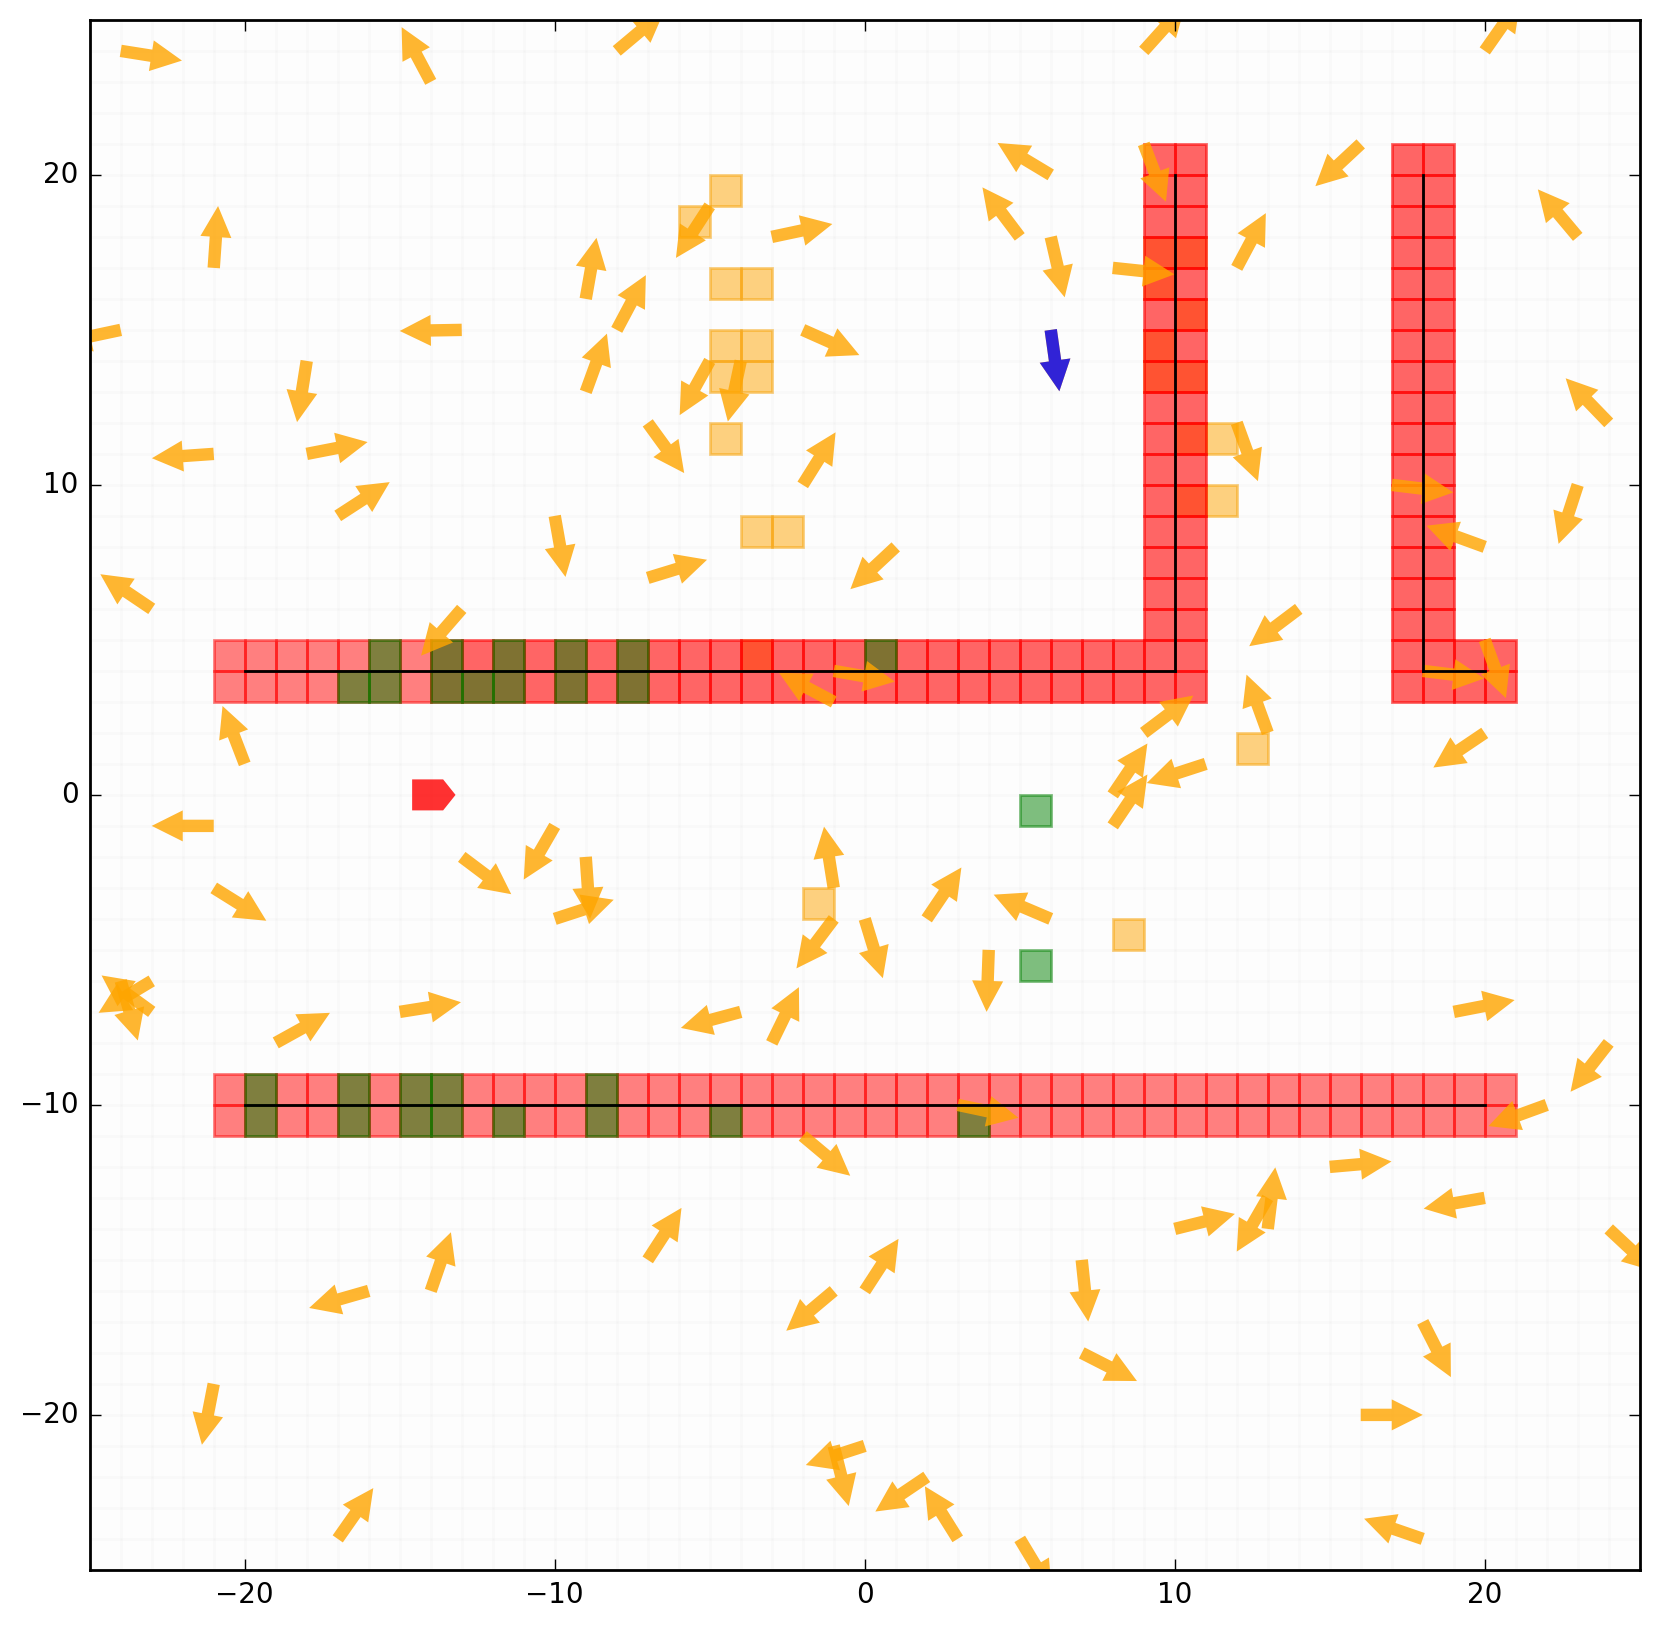

In [27]:
if __name__ == '__main__':
    
    r = Robot(-14, 0, 0, 0, 0)
    w = get_walls()
    s = Sensor(r, w)
    gm = GlobalMap(50, 50, w)
    lm = LocalMap(s, r, w)
    p = get_particles(100, gm, lm)
    
    # 正しいパーティクルを注入
    #for i in range(0, 2):
    #    p[i].x = r.x
    #    p[i].y = r.y
    #    p[i].th = r.th
    
    init_playground(50, 50, r, p, w, s, gm, lm)

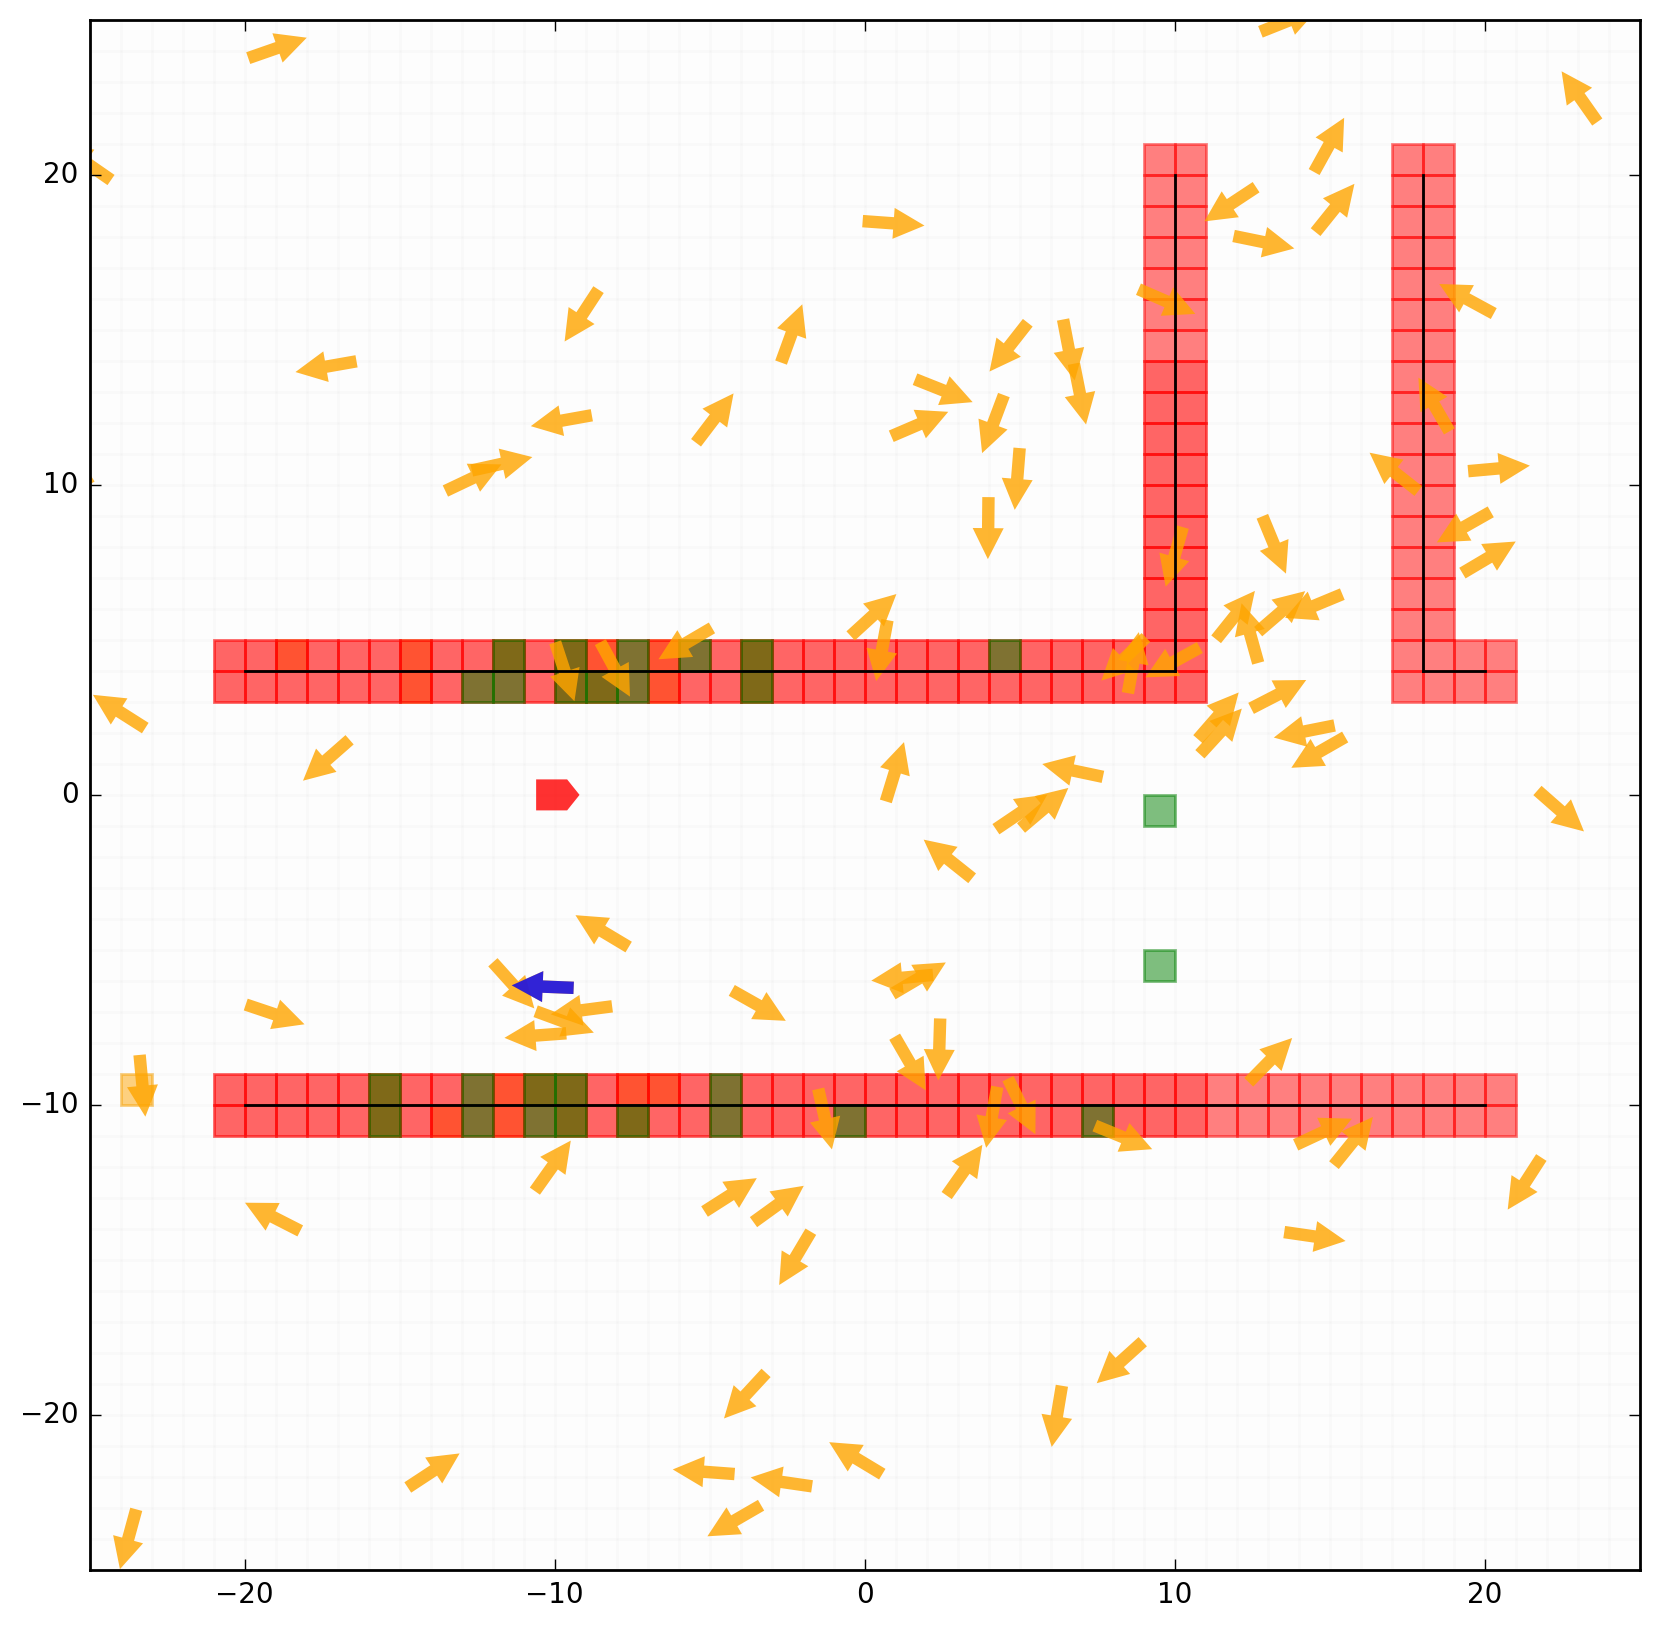

In [28]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

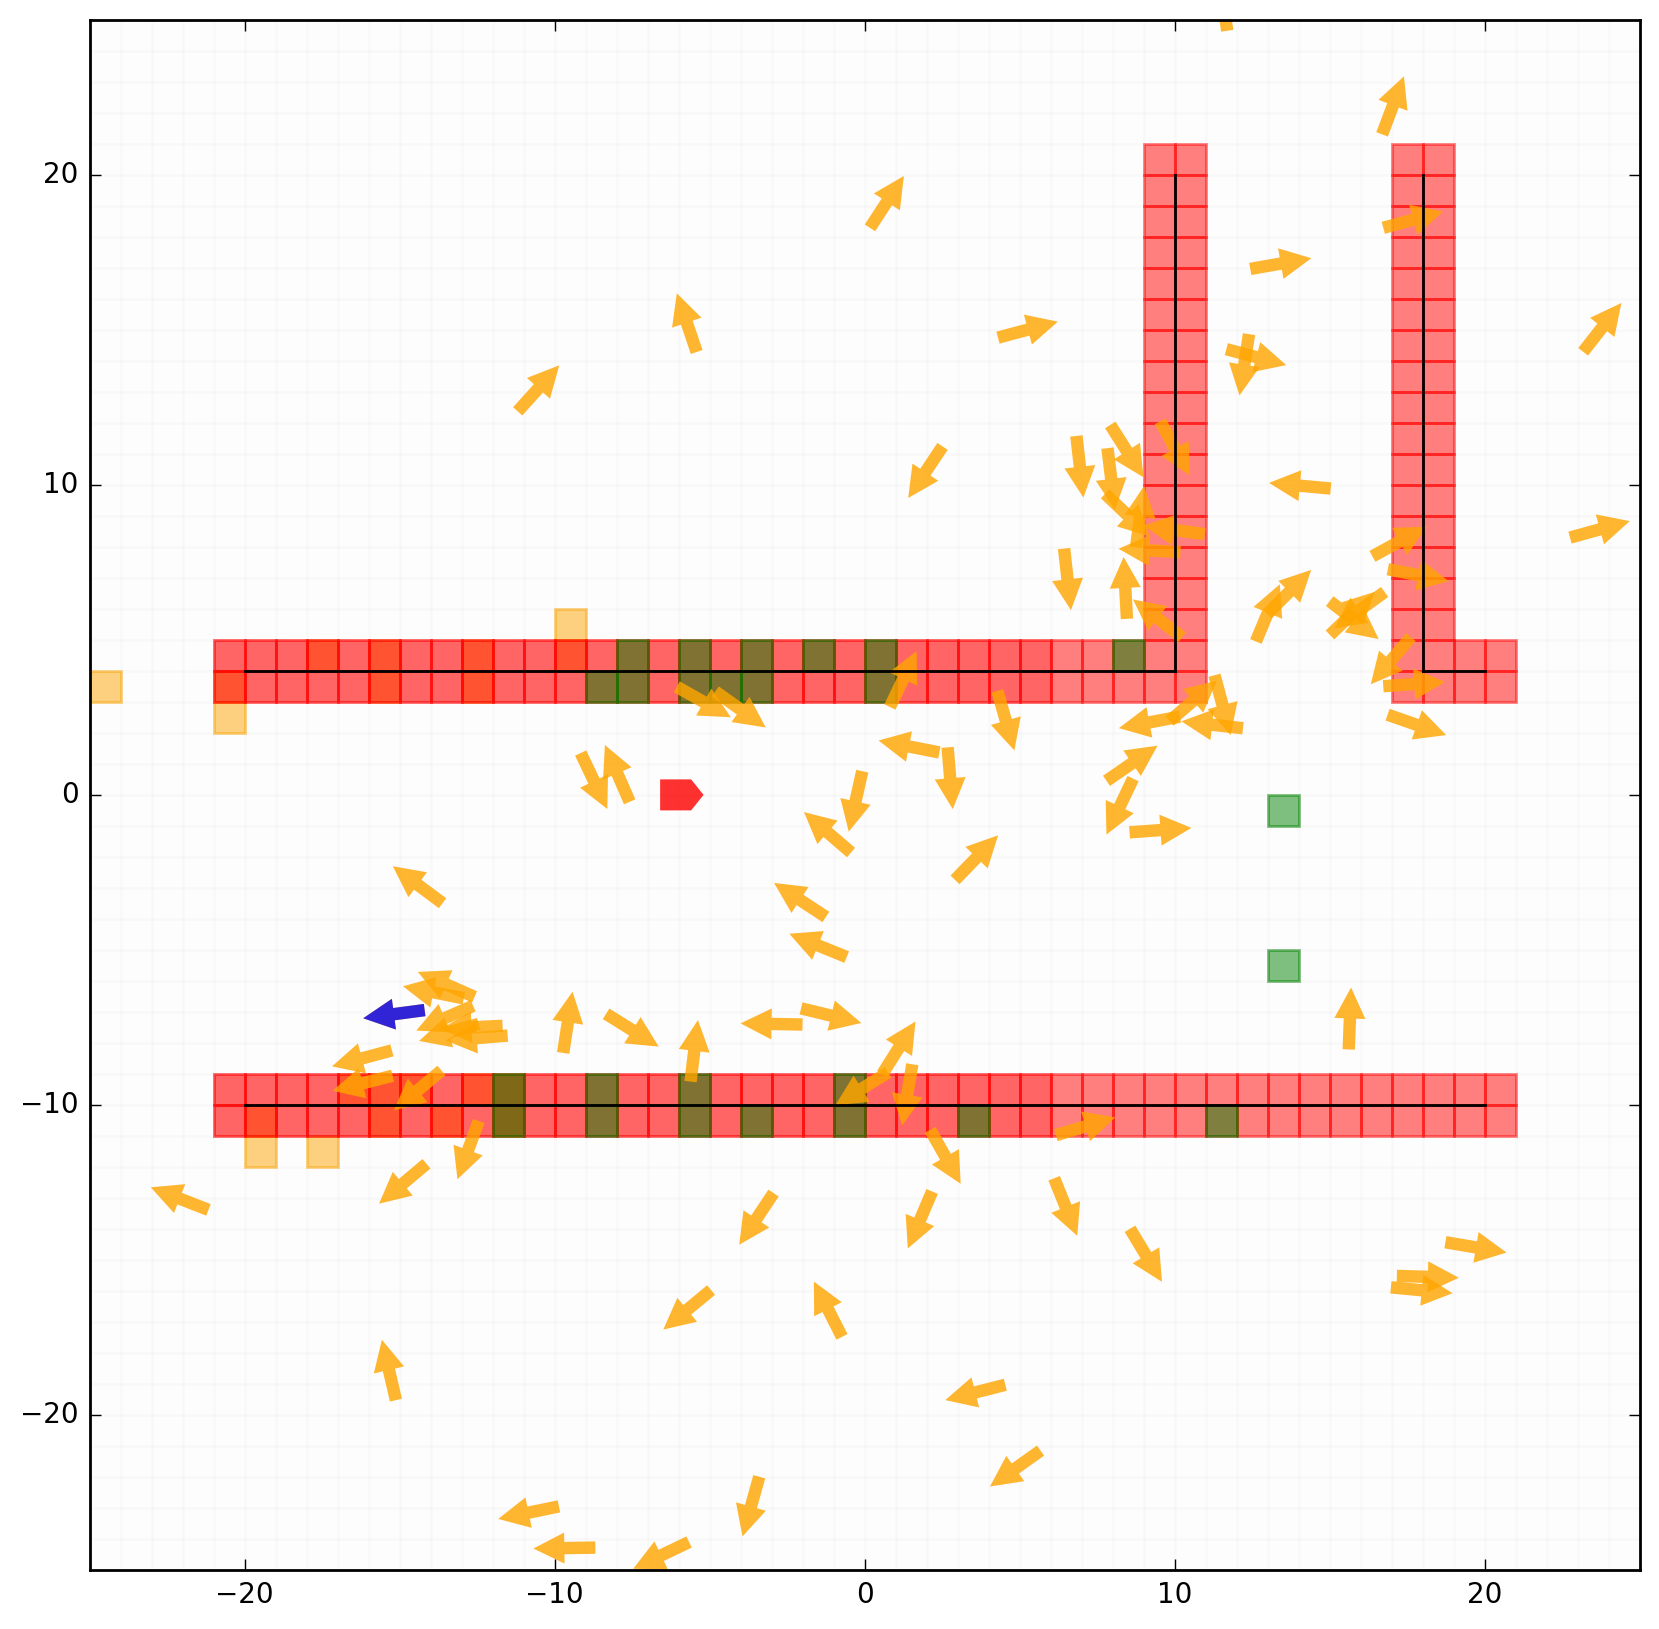

In [29]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

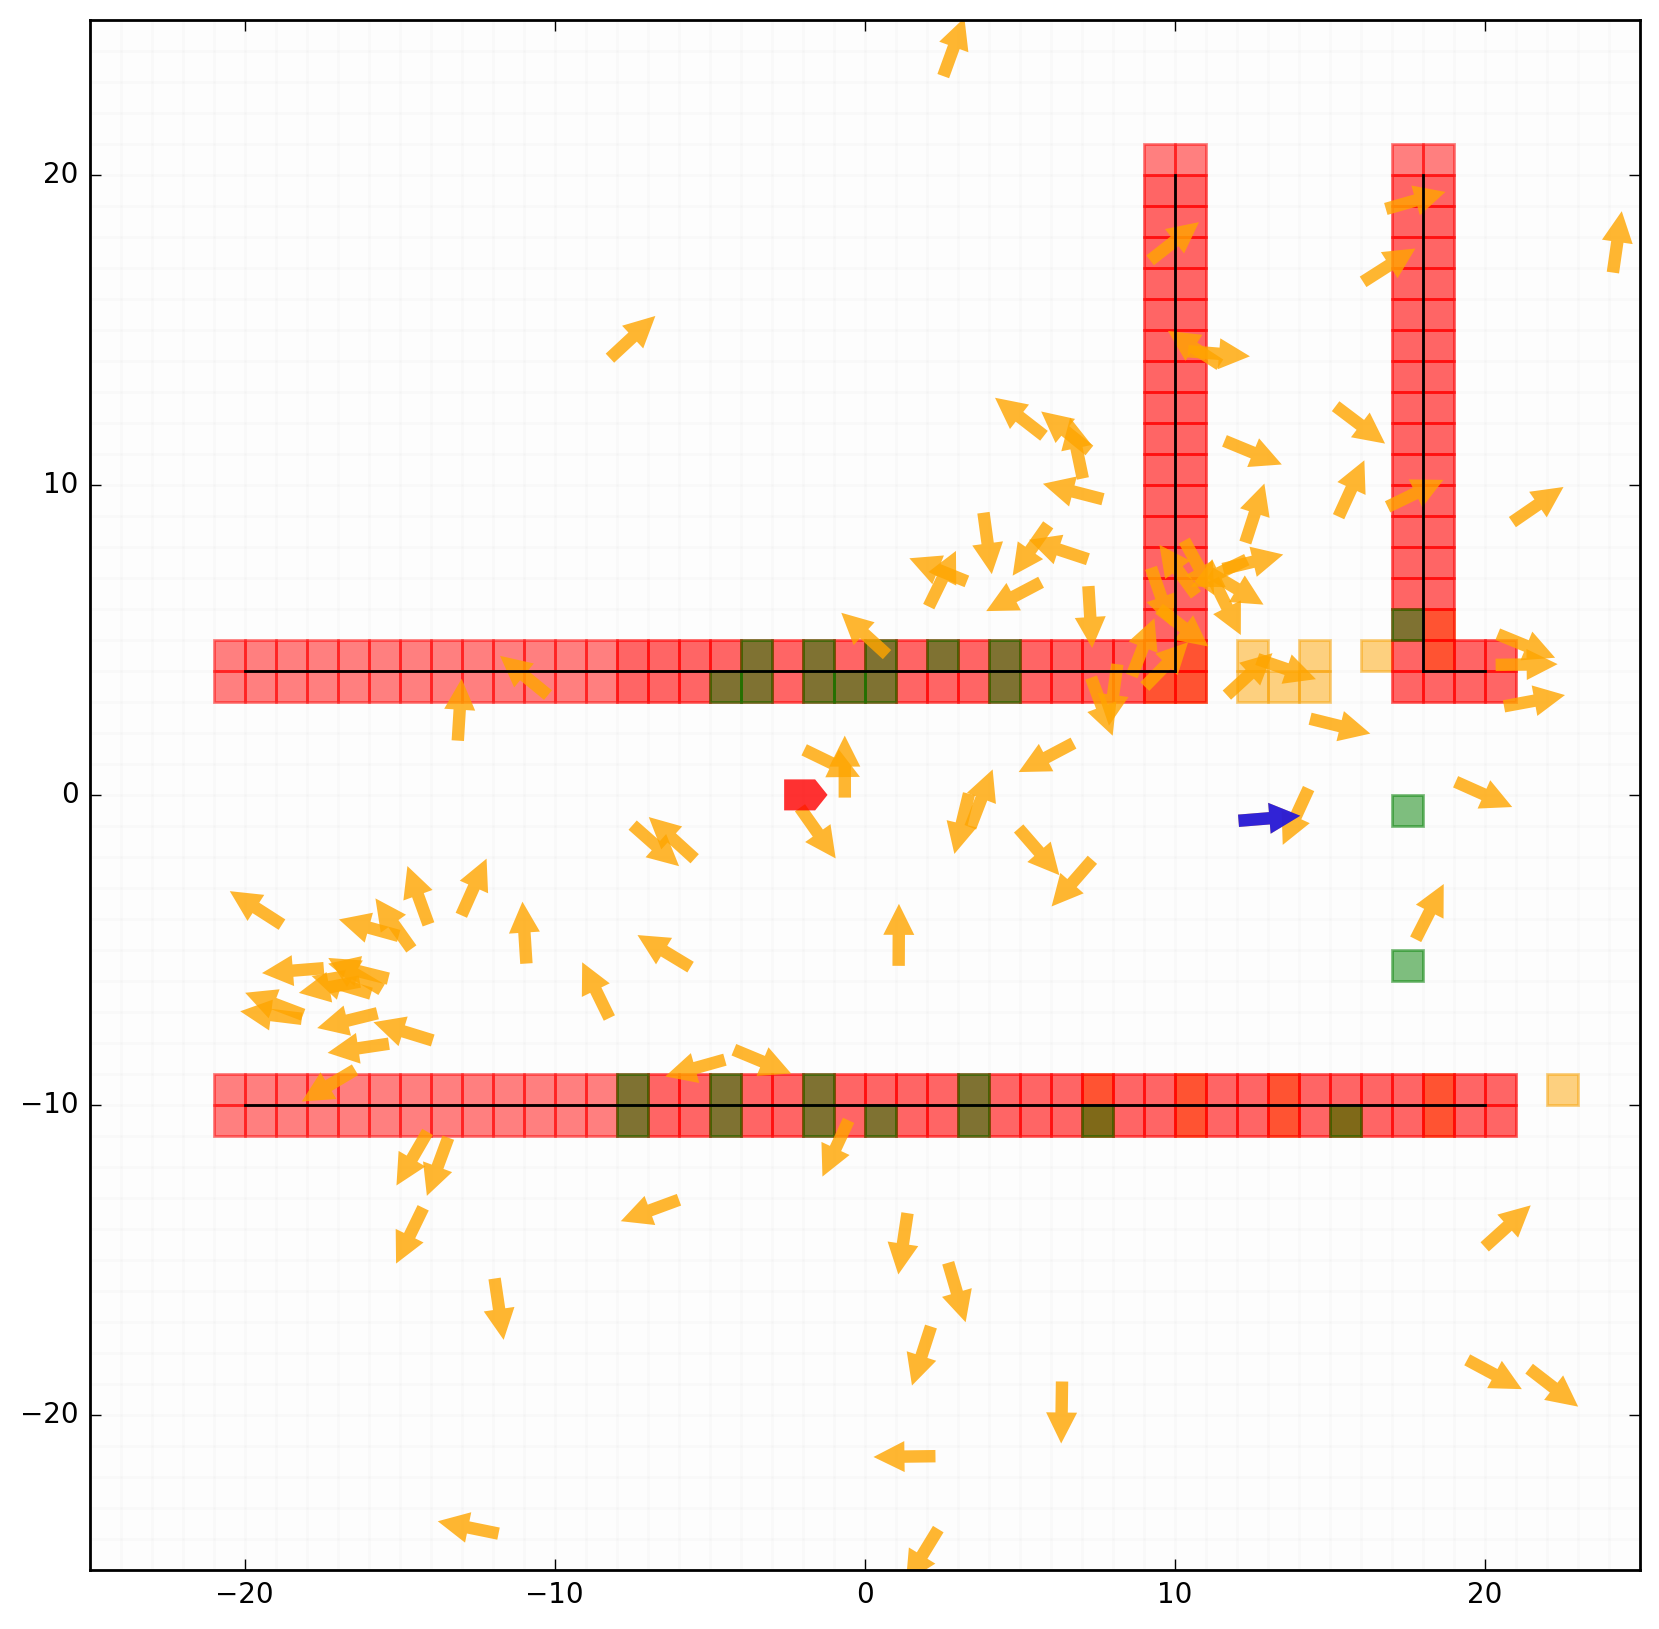

In [30]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

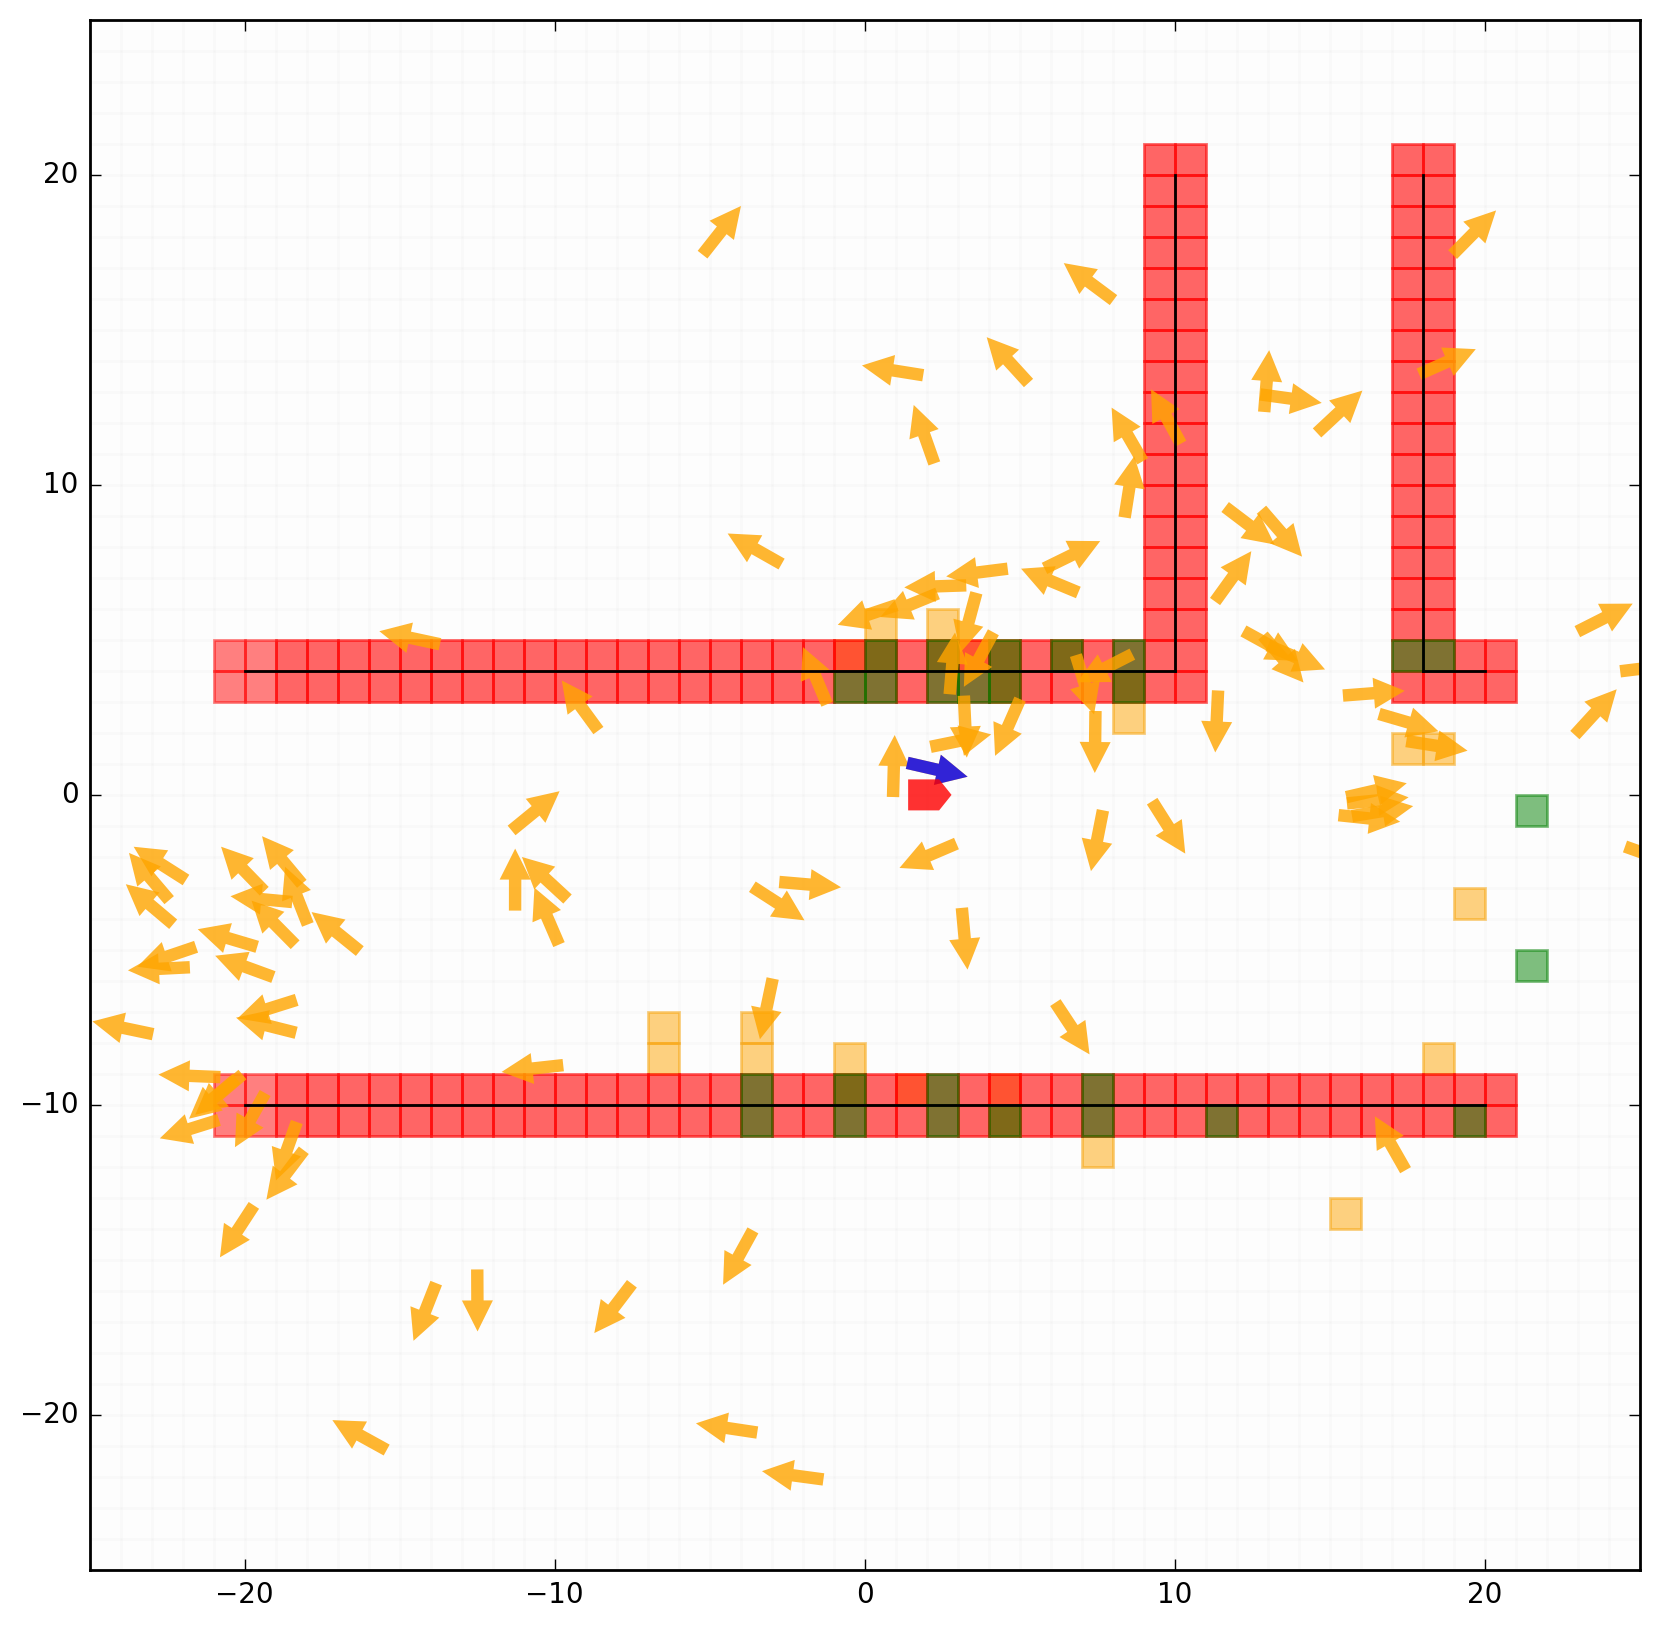

In [31]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

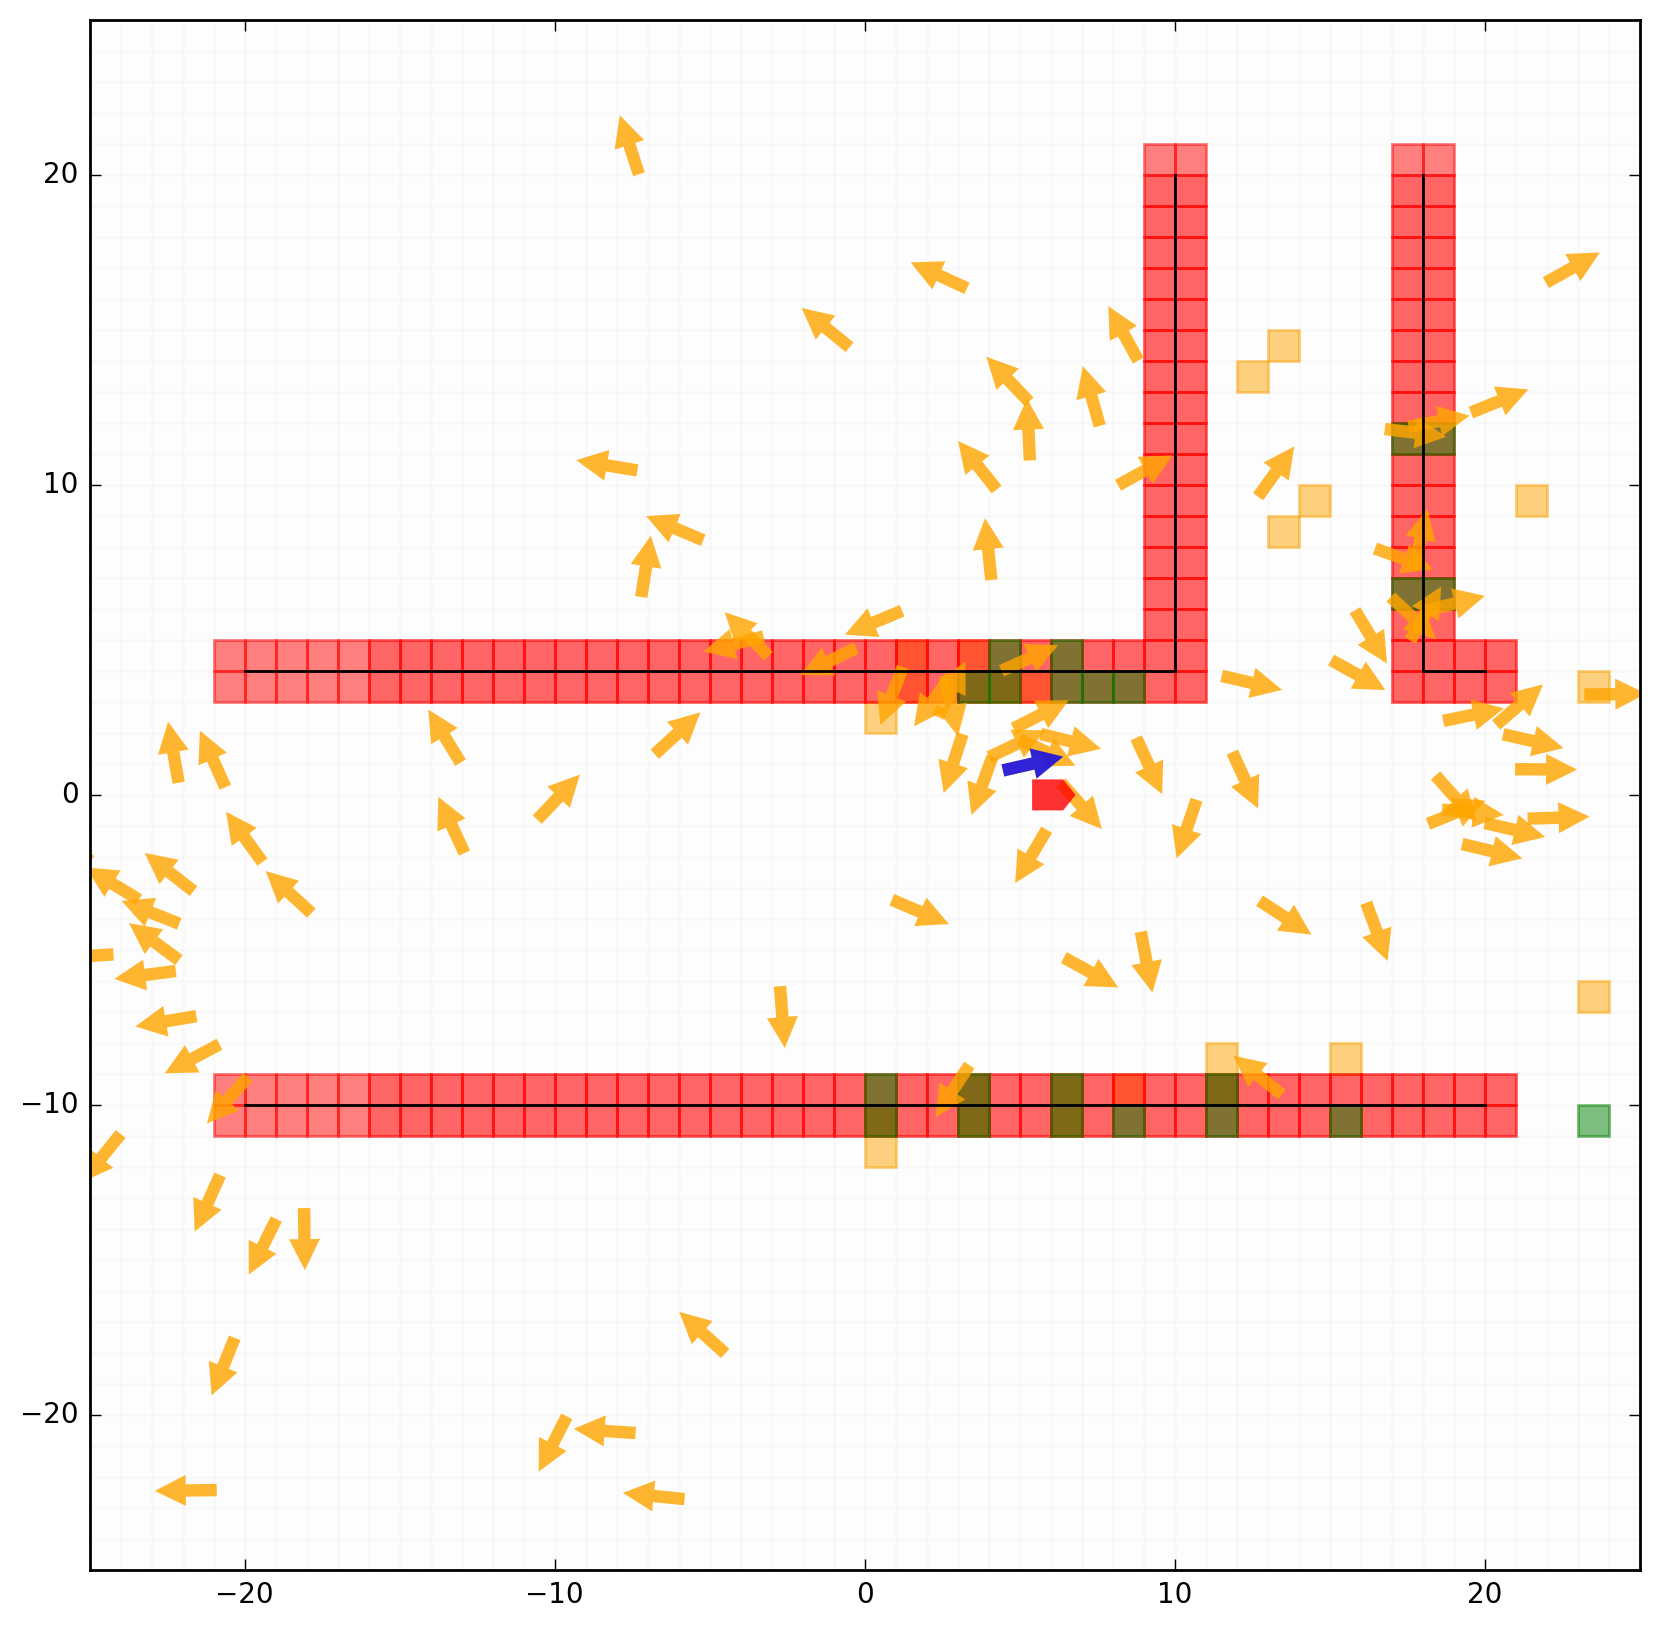

In [32]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

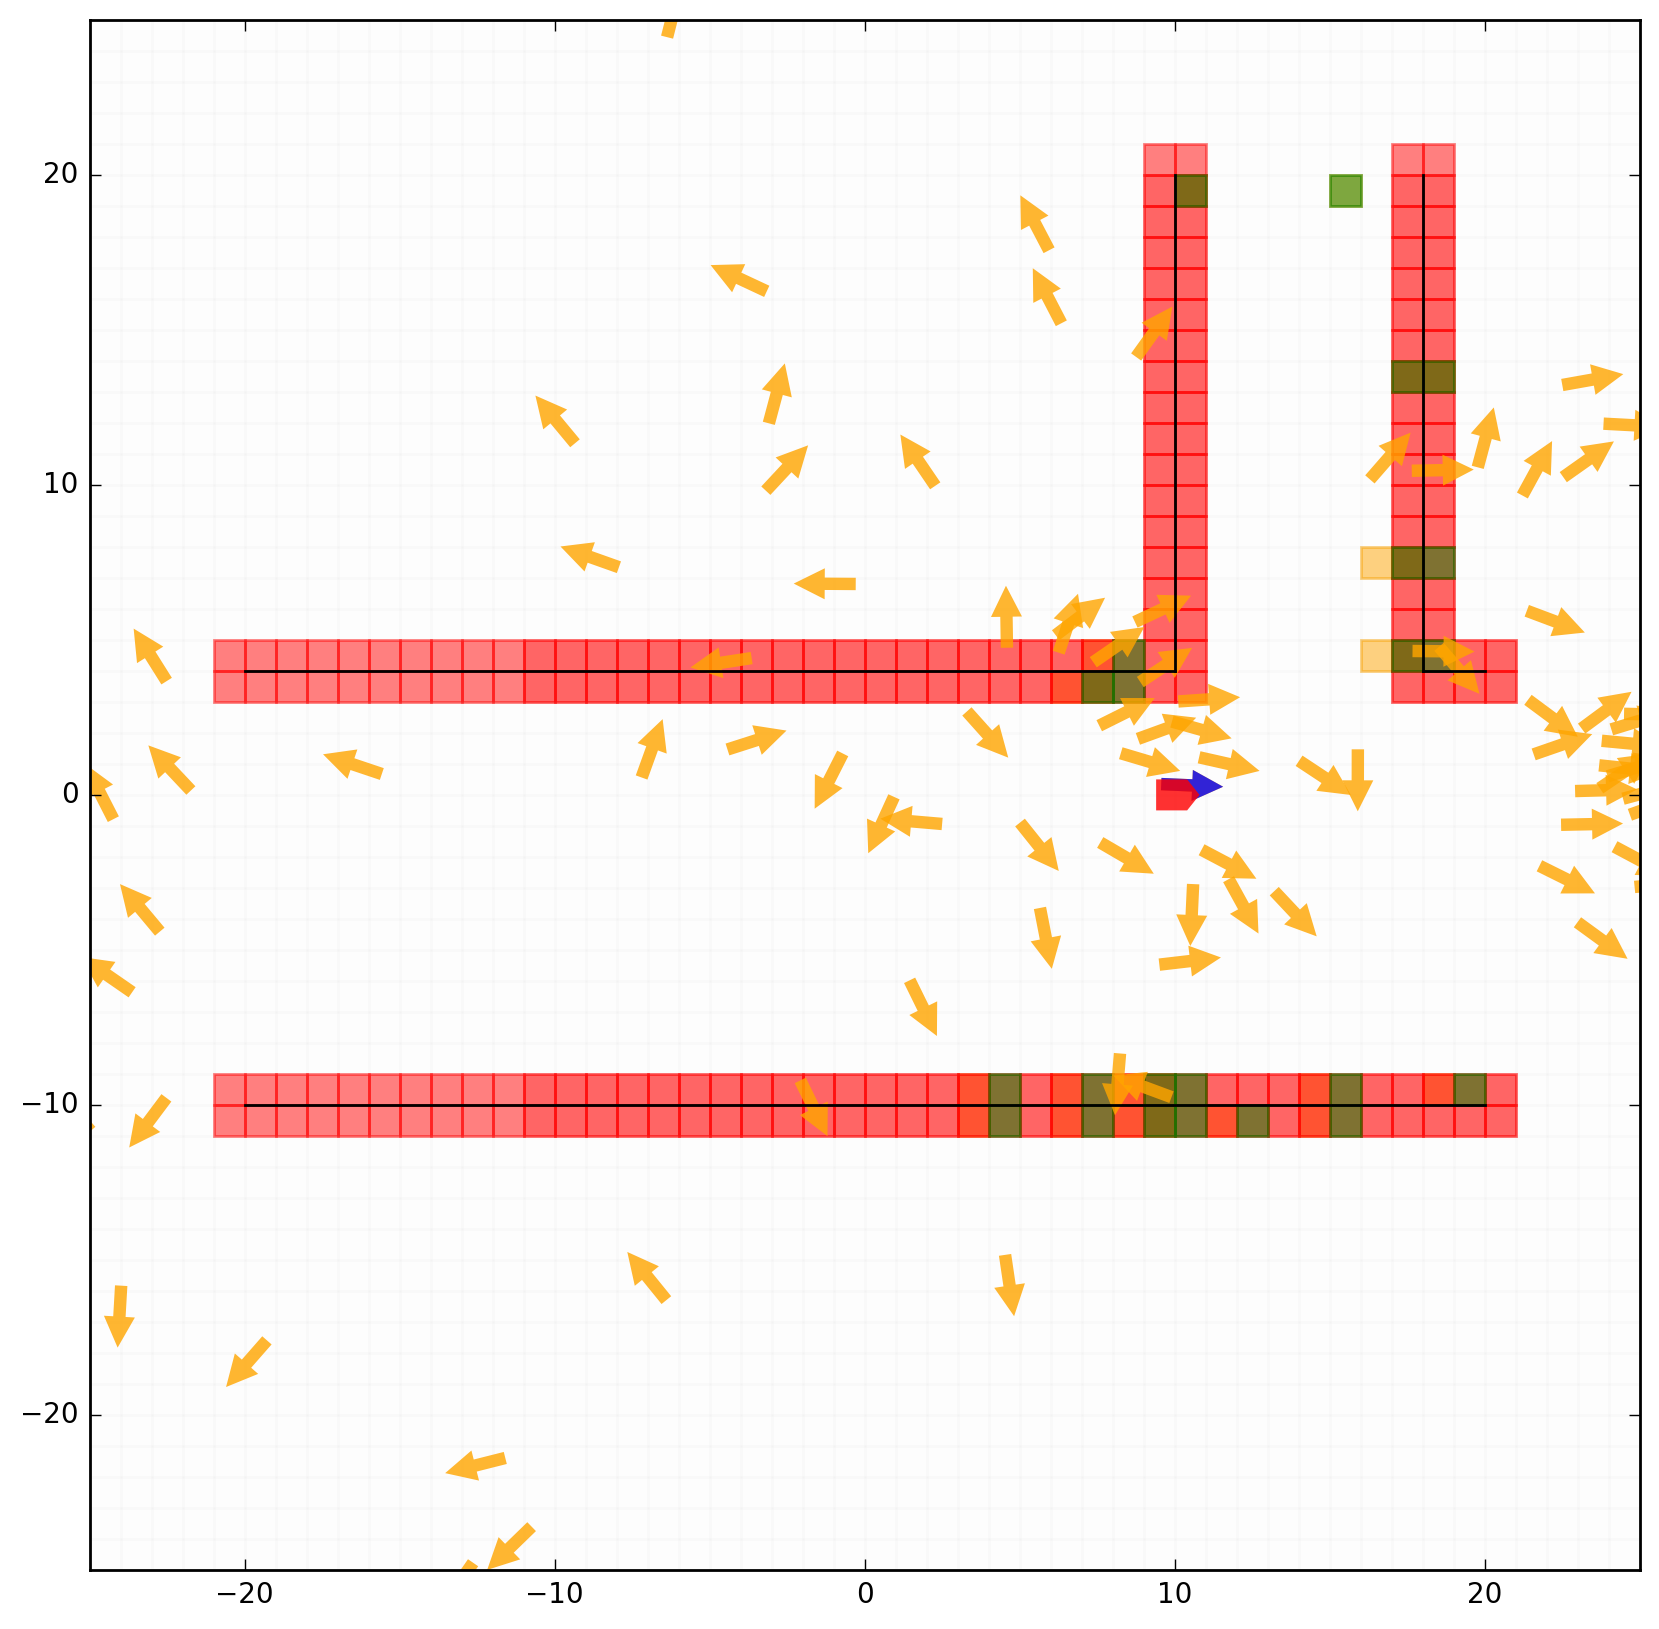

In [33]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

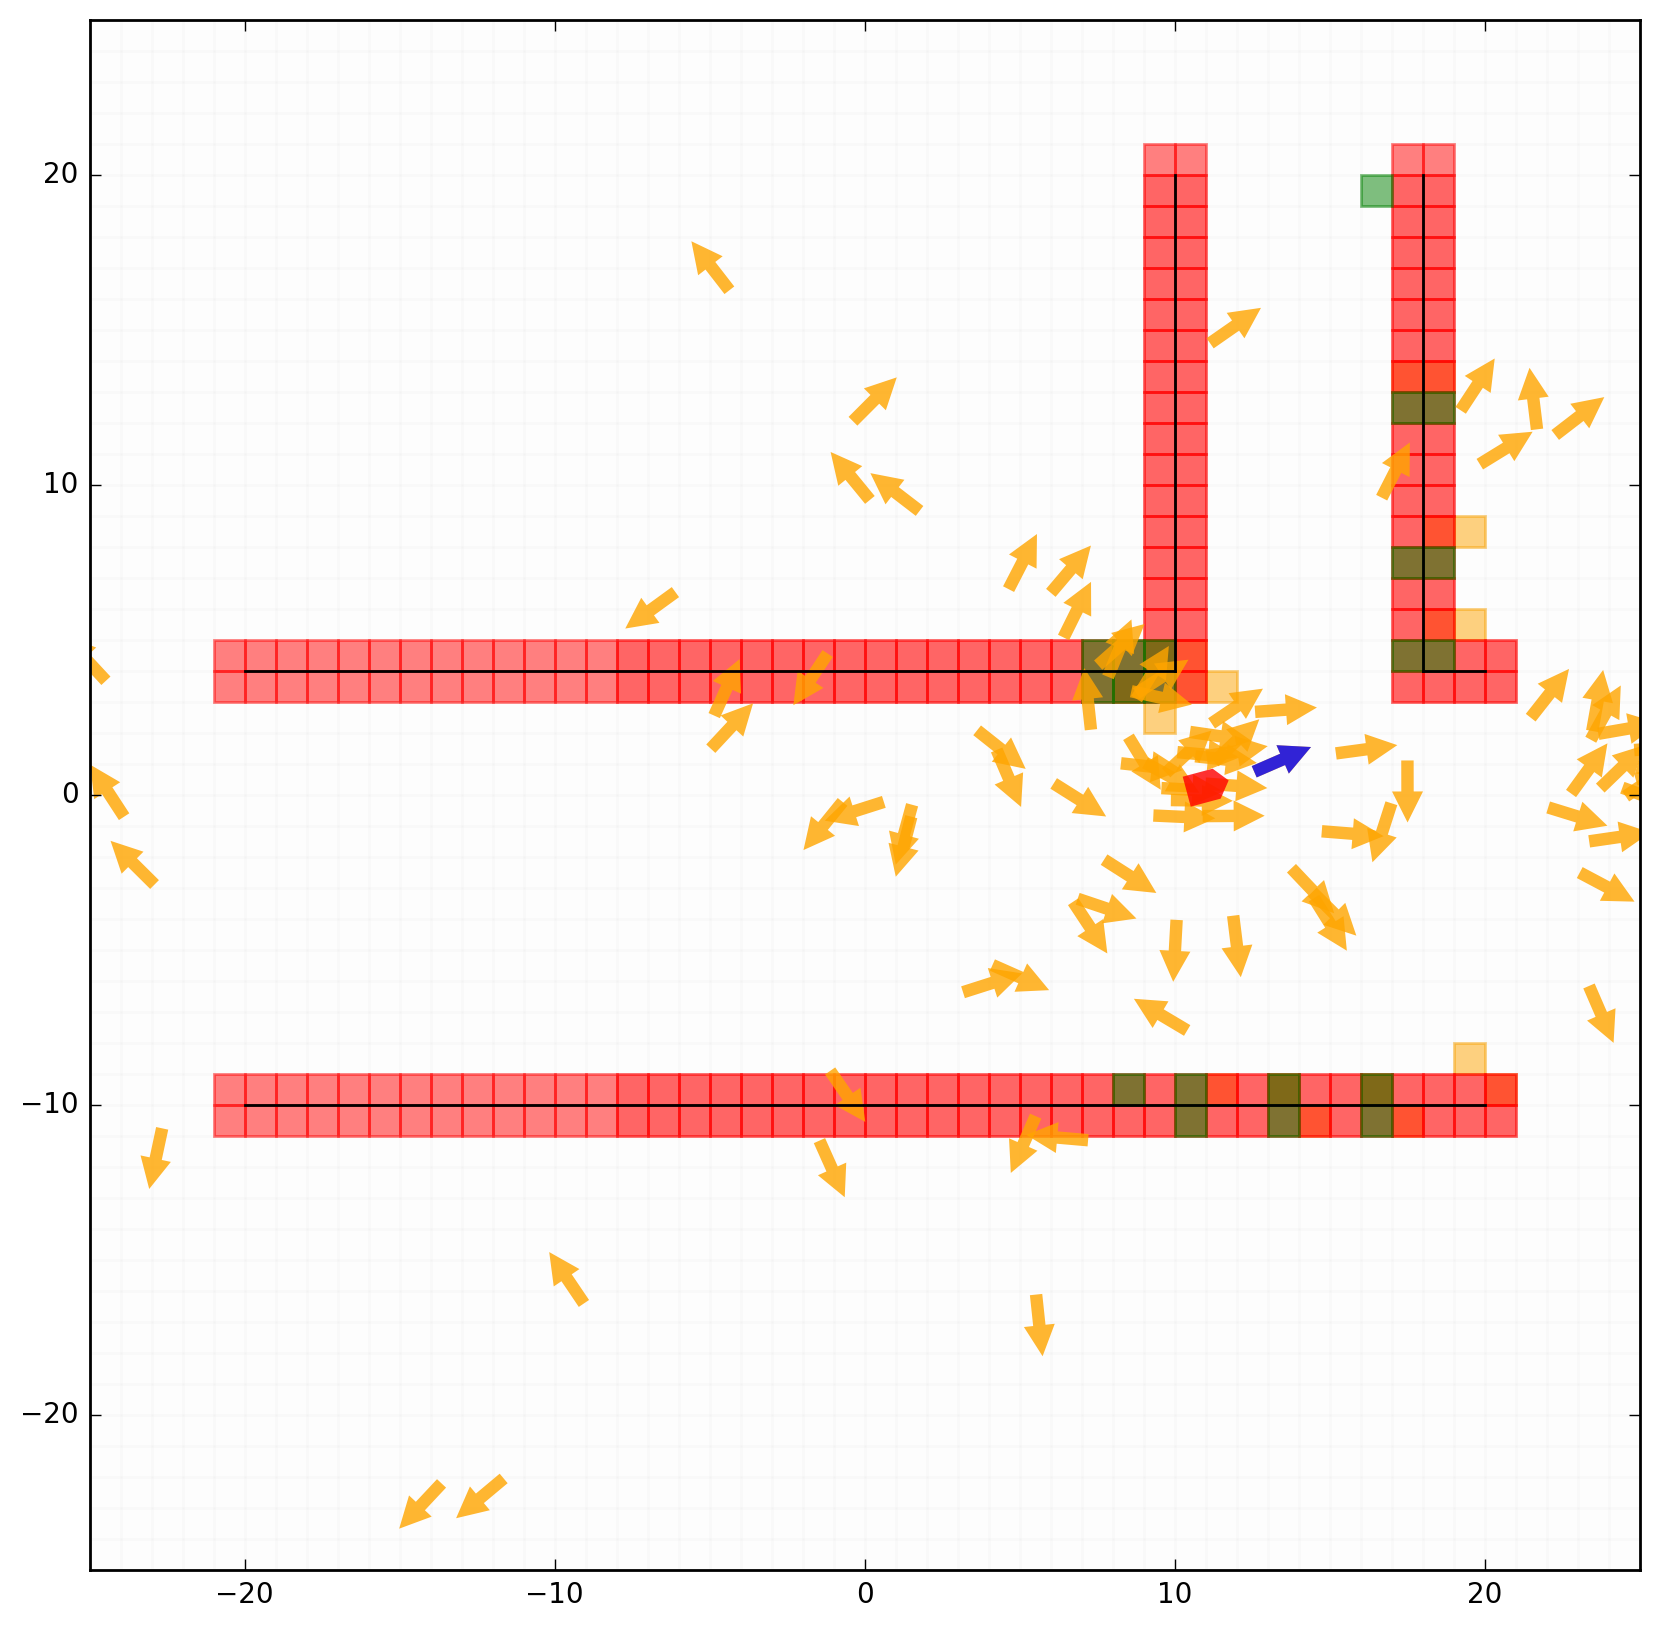

In [34]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

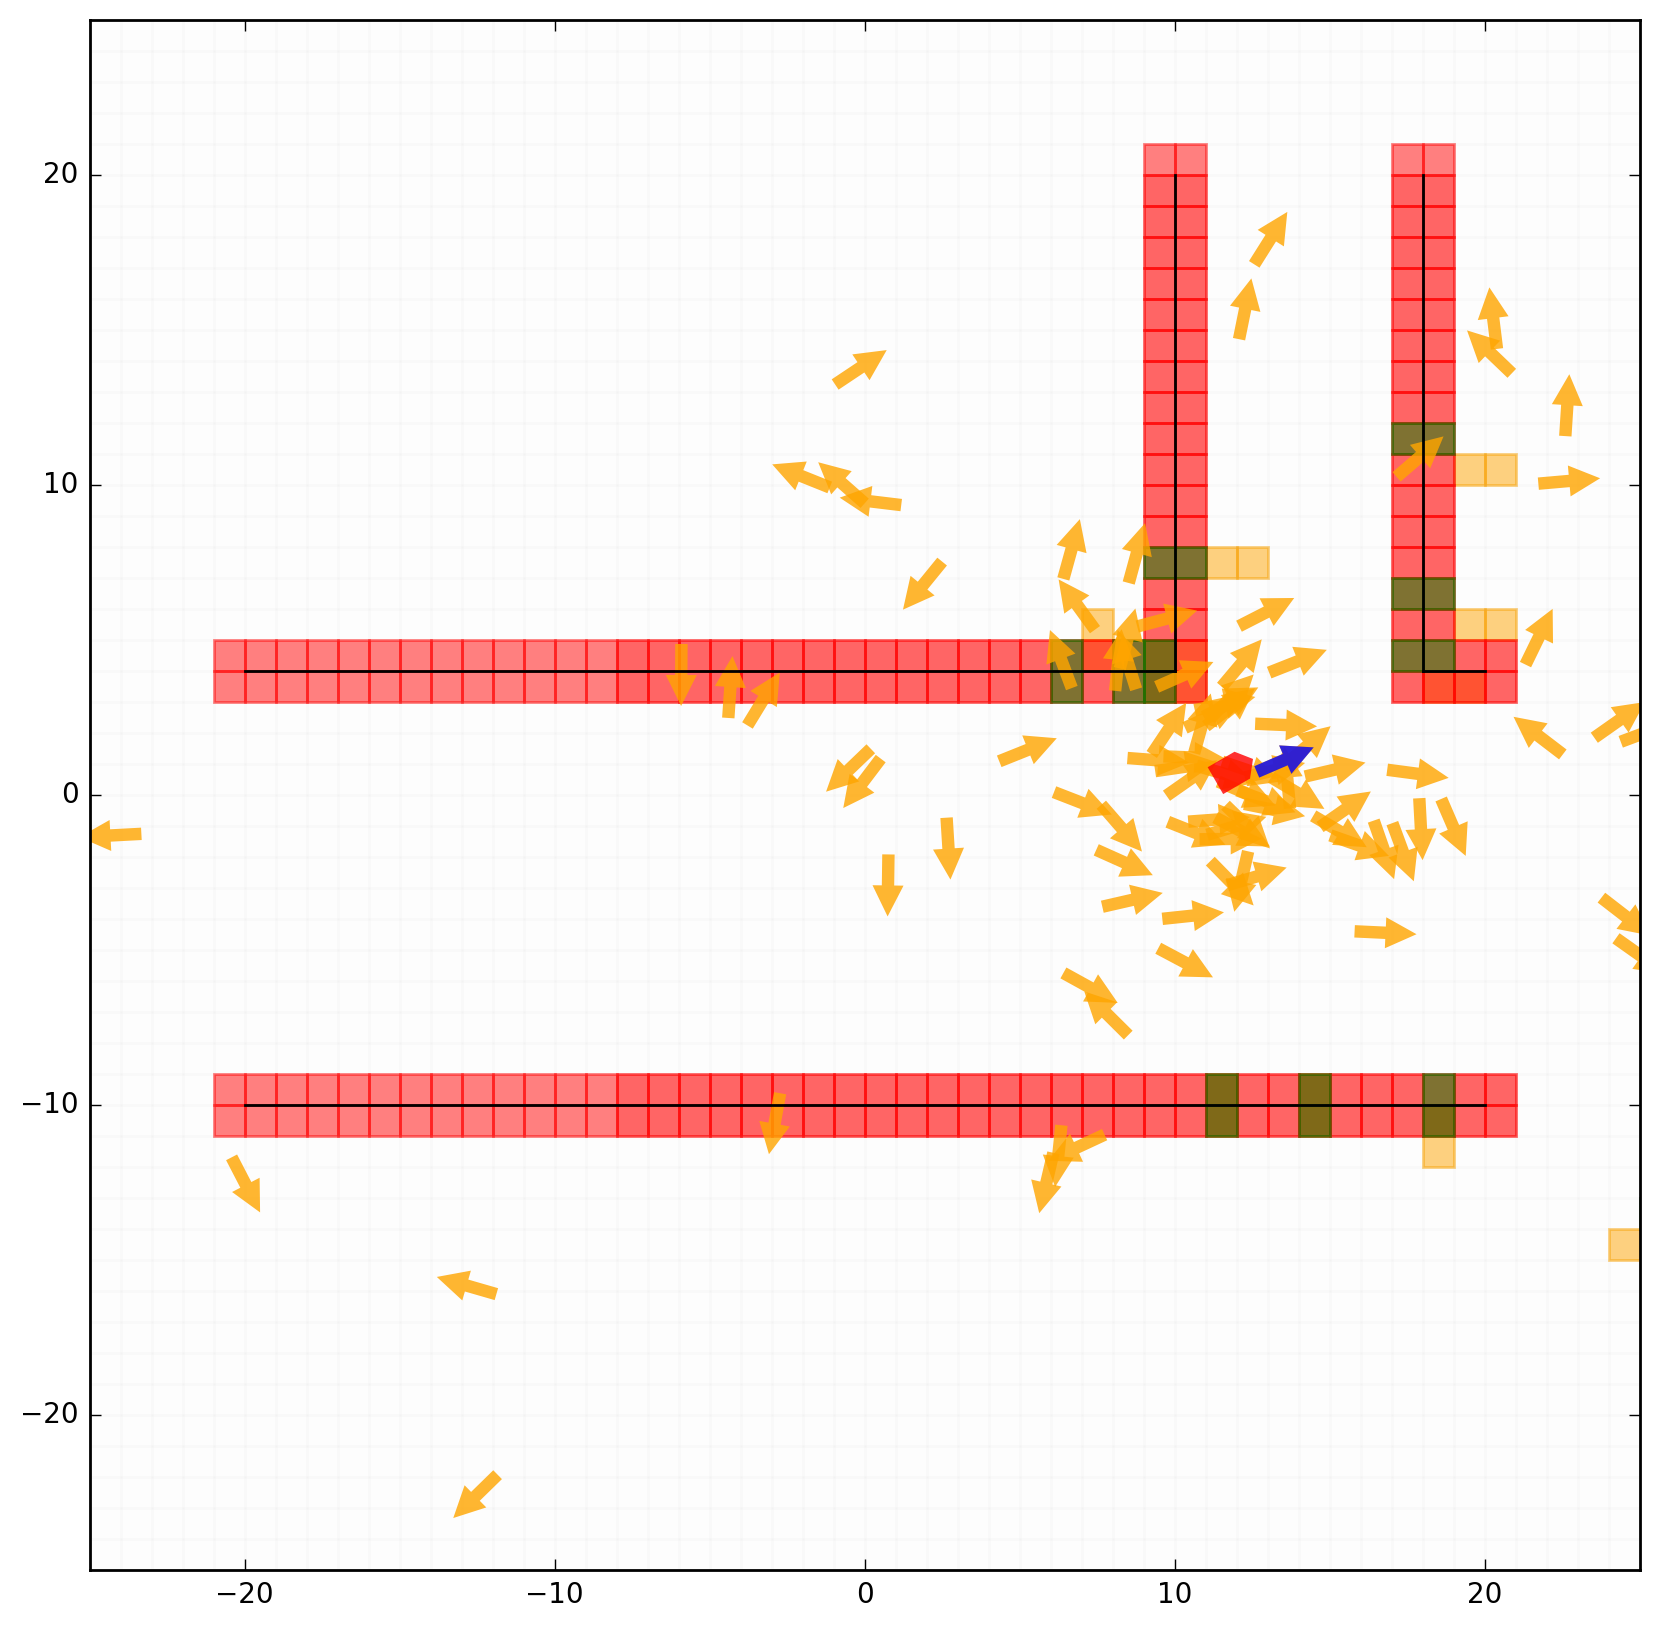

In [35]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

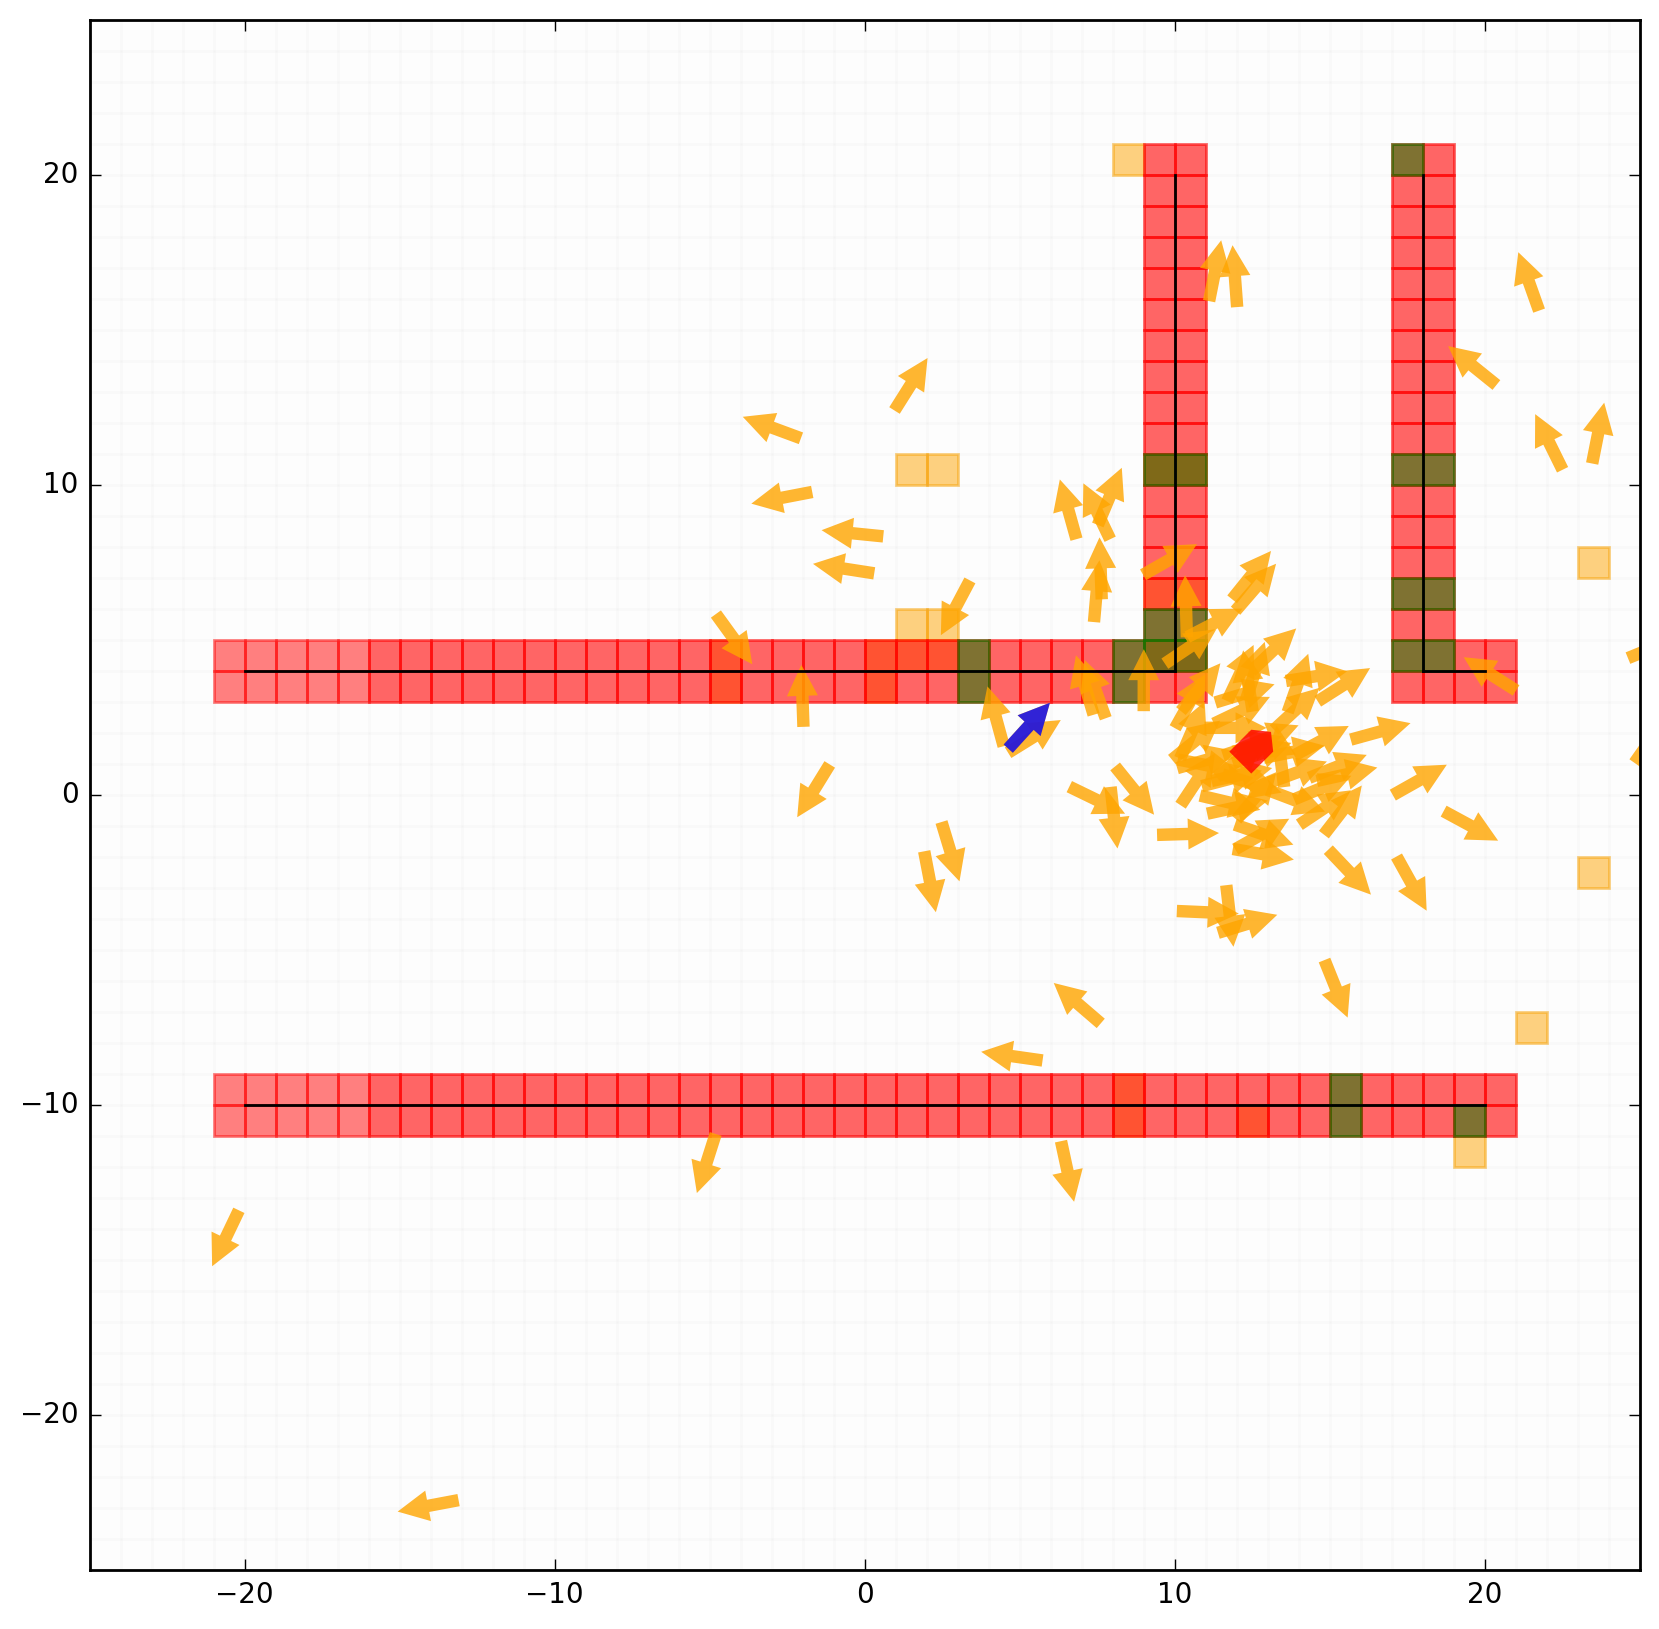

In [36]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

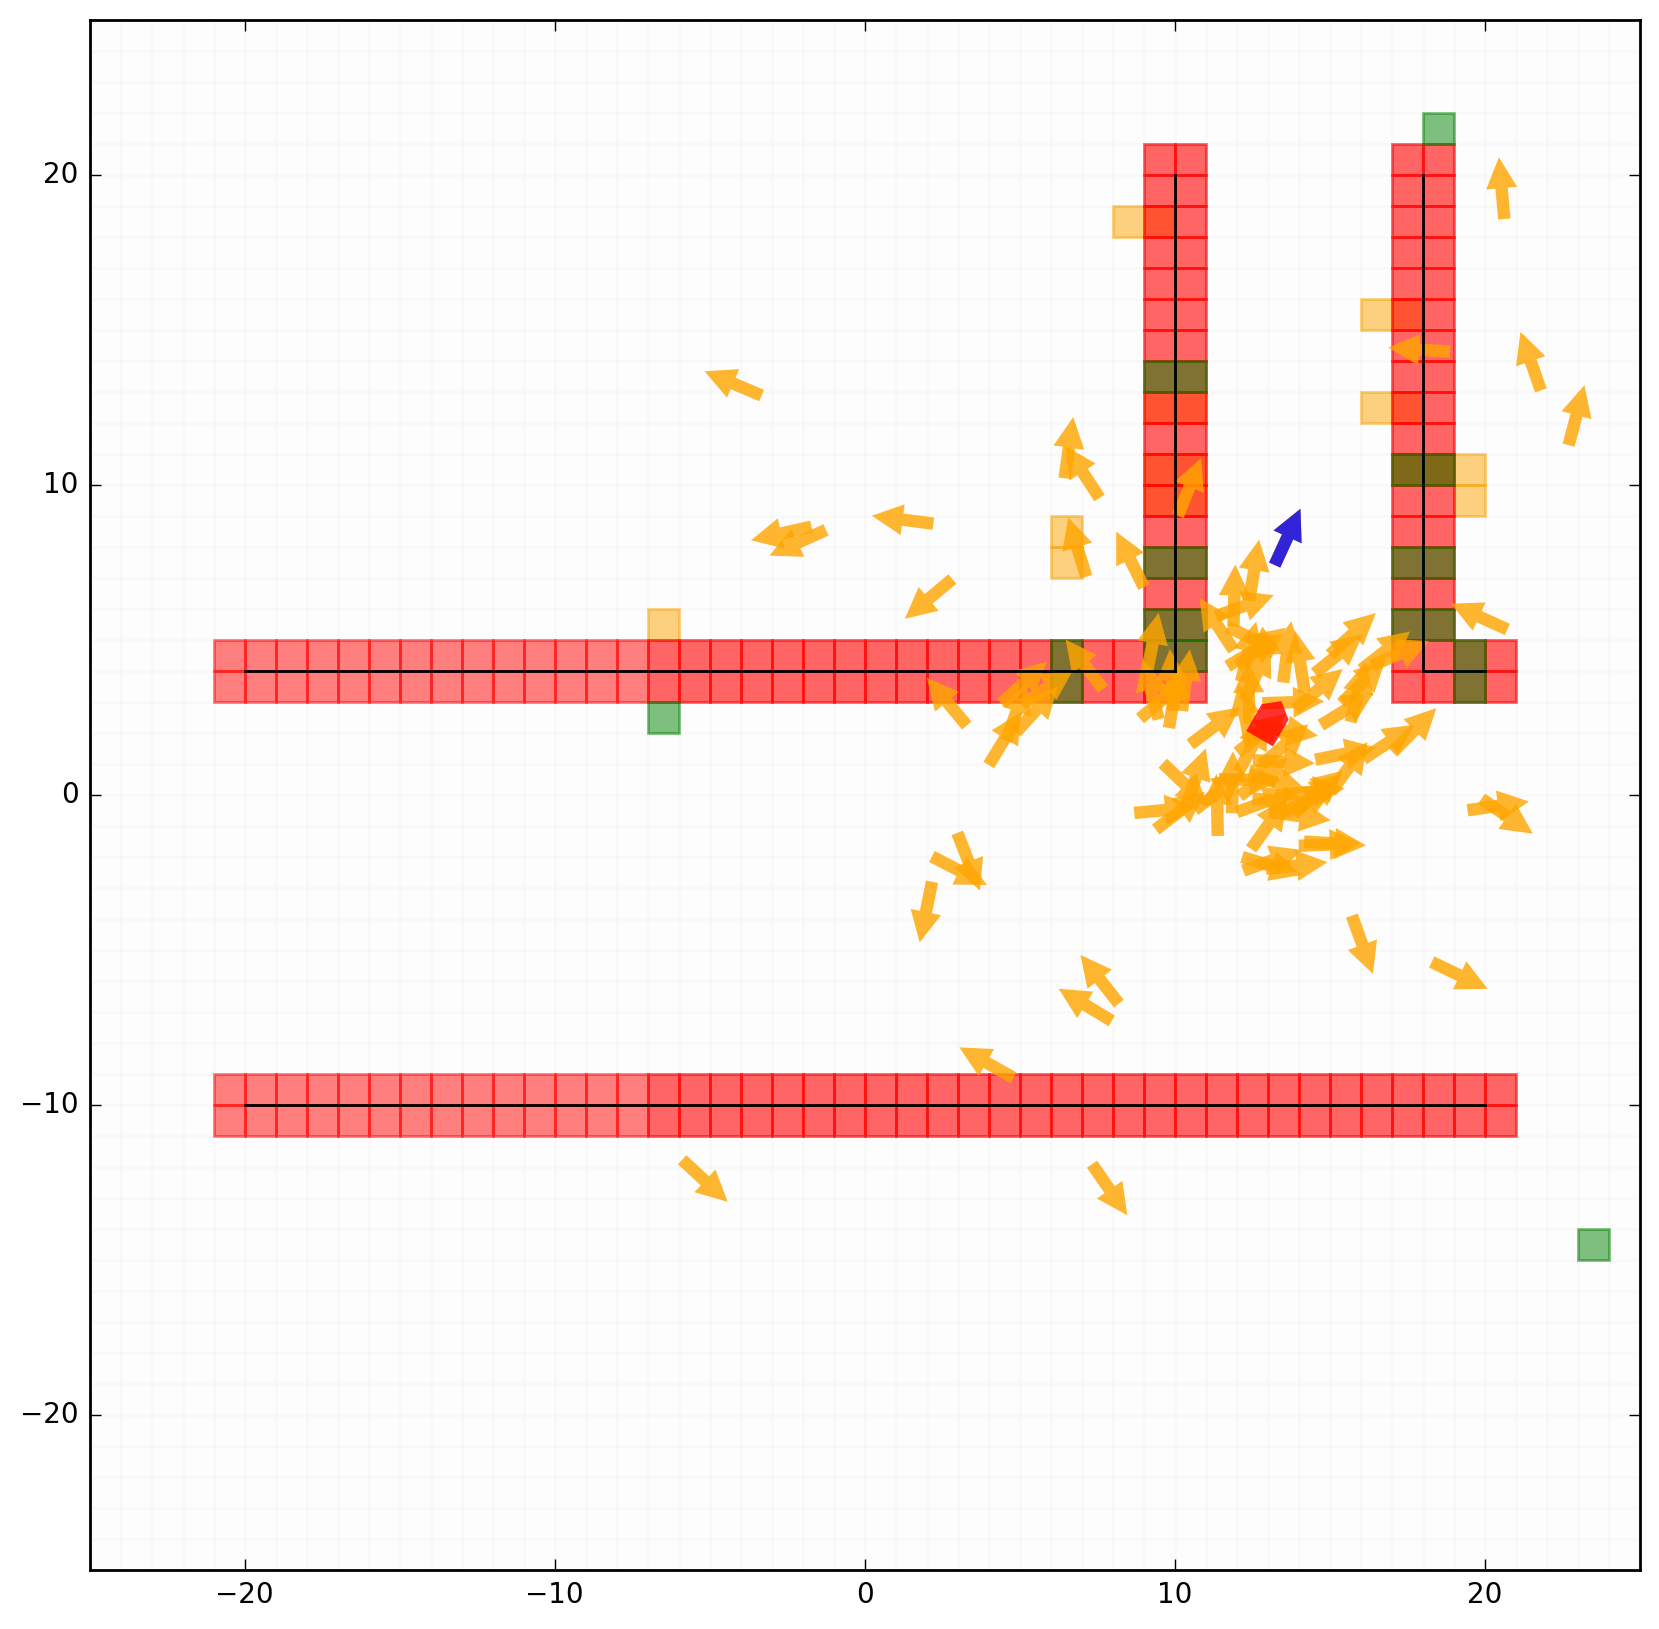

In [37]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

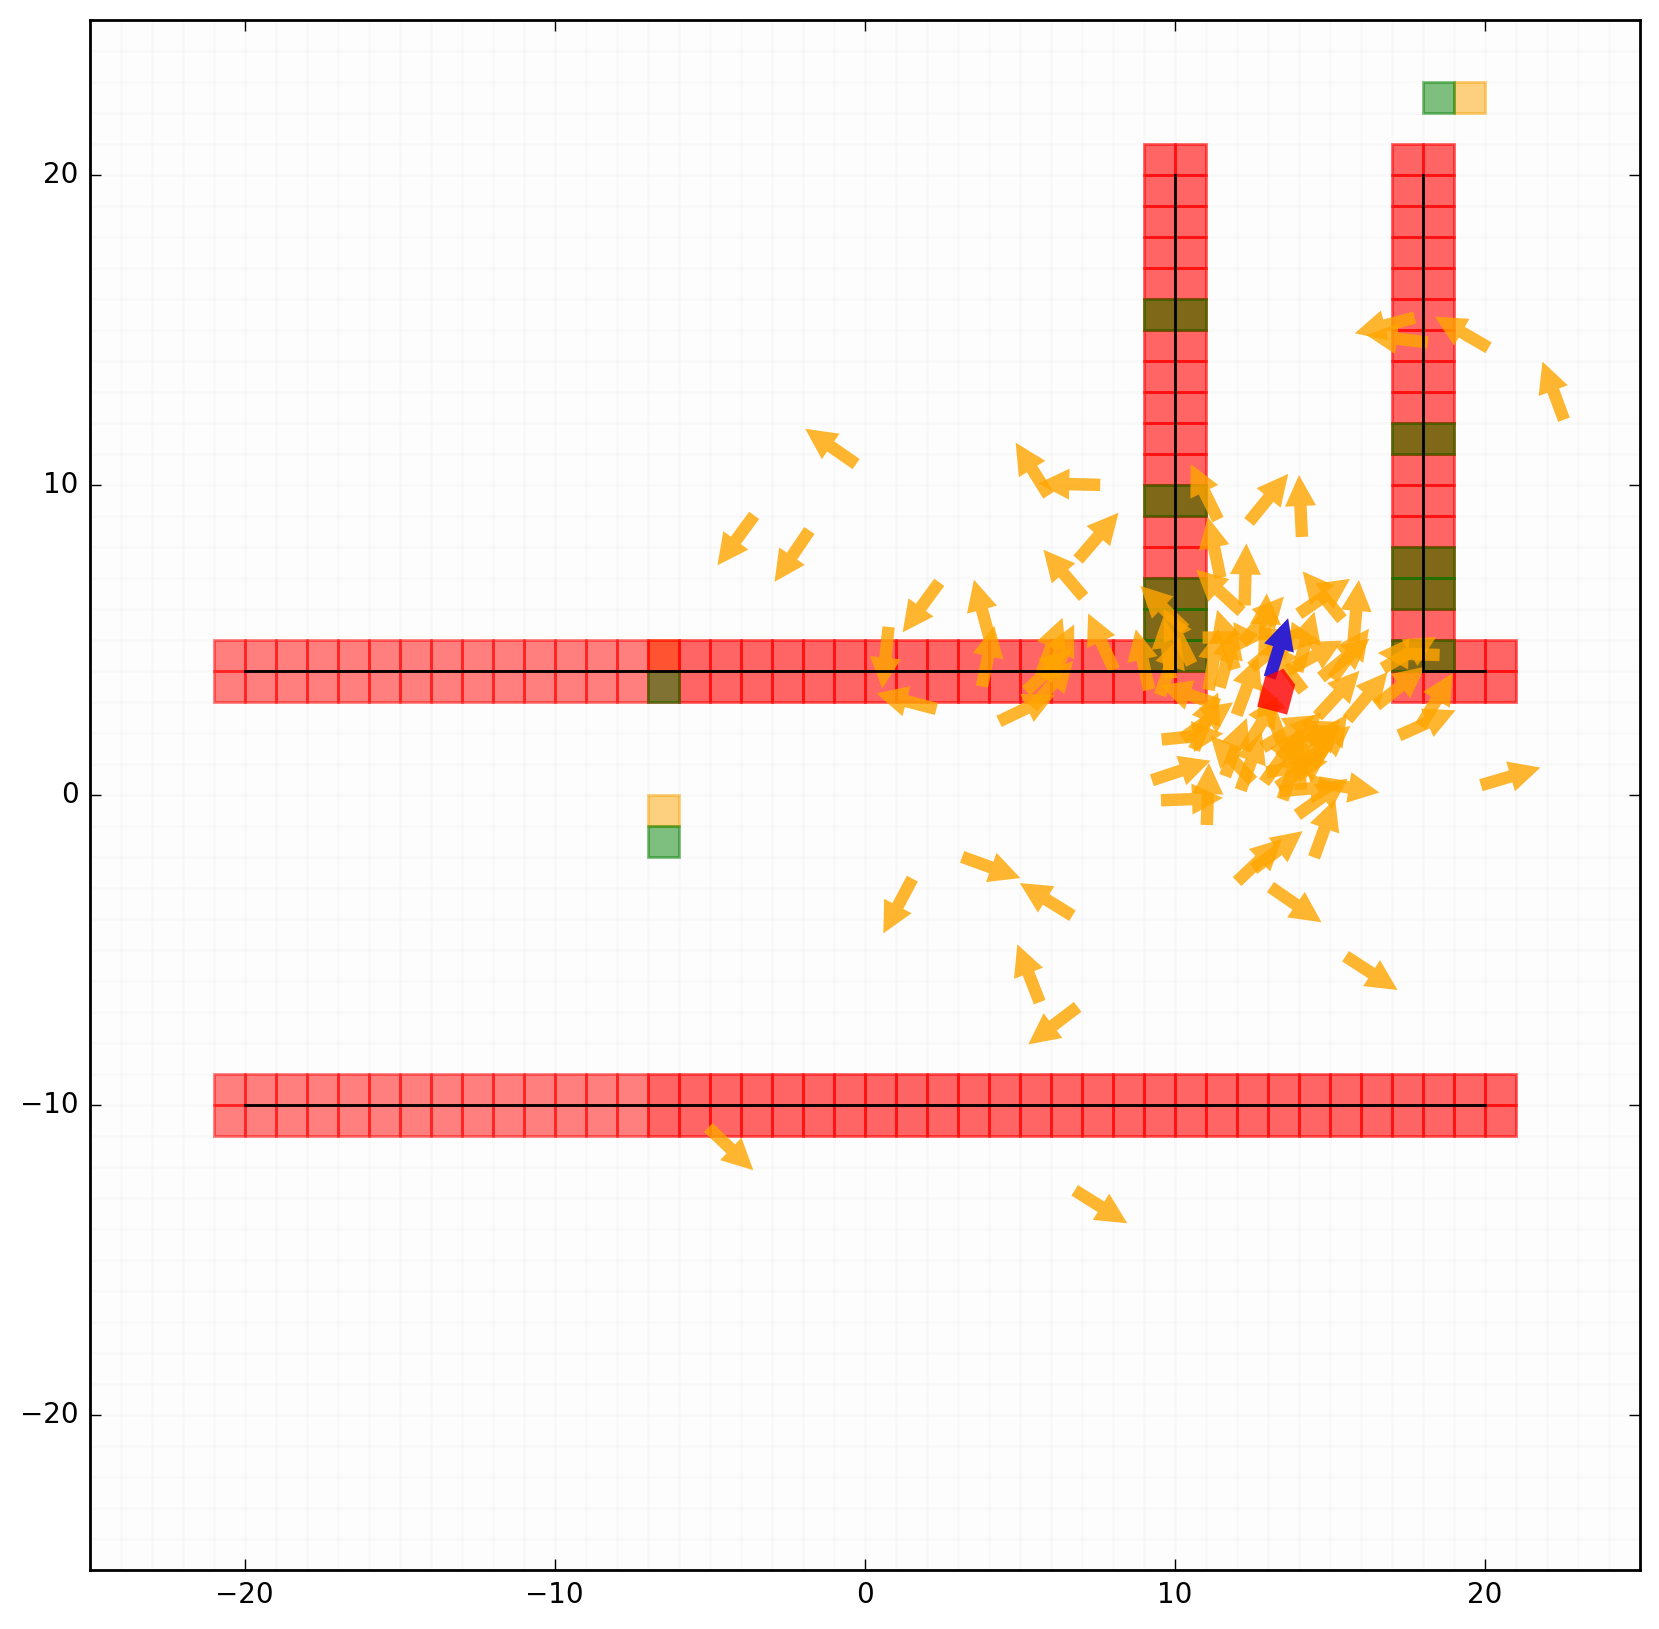

In [38]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

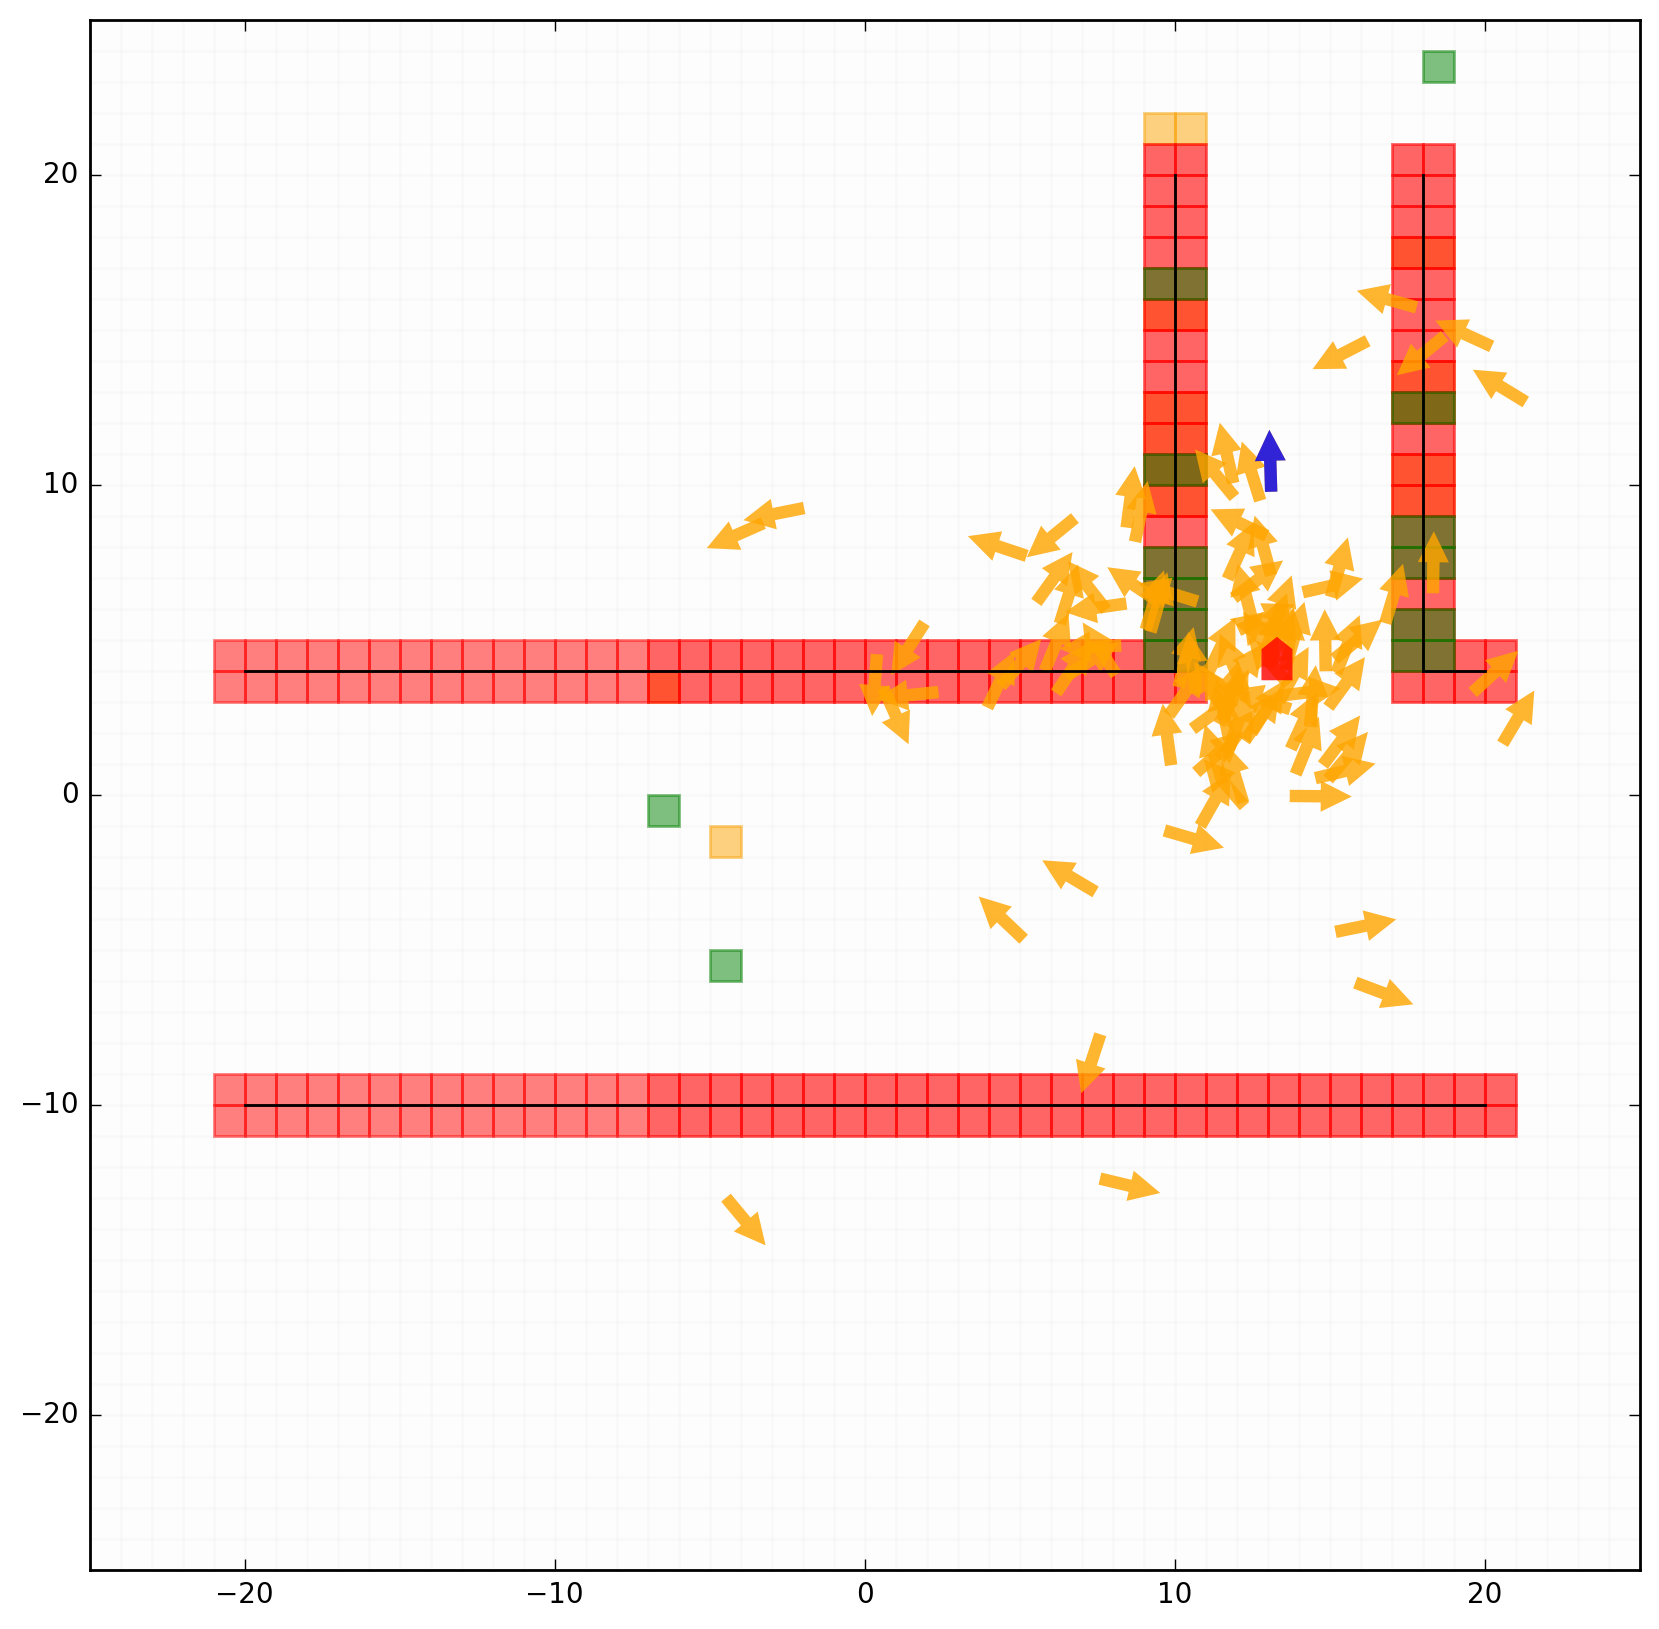

In [39]:
set_velocity(r, 1, 15)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

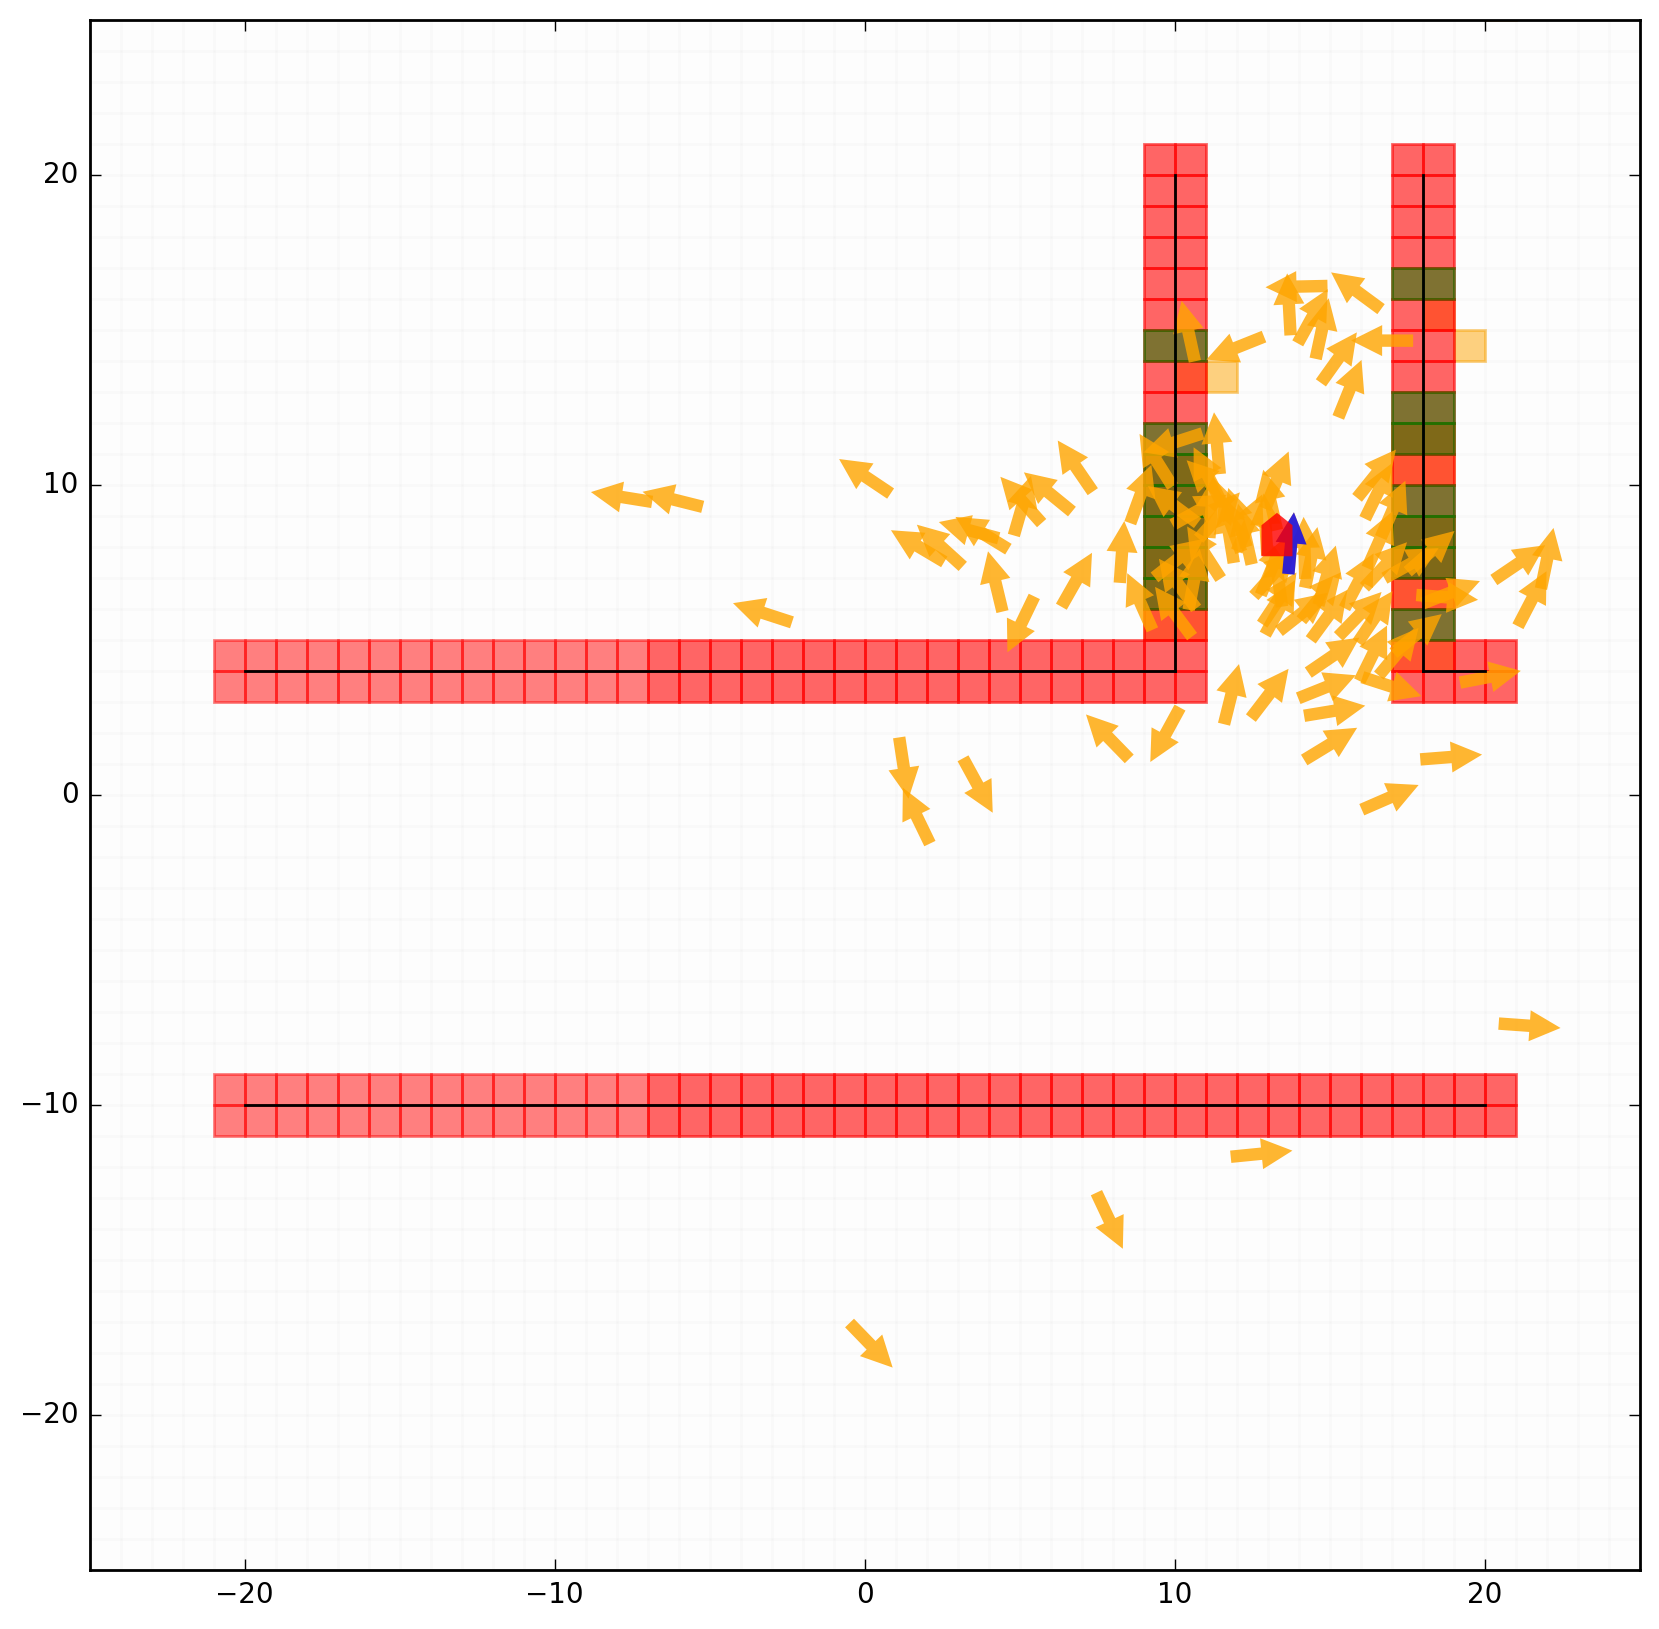

In [40]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

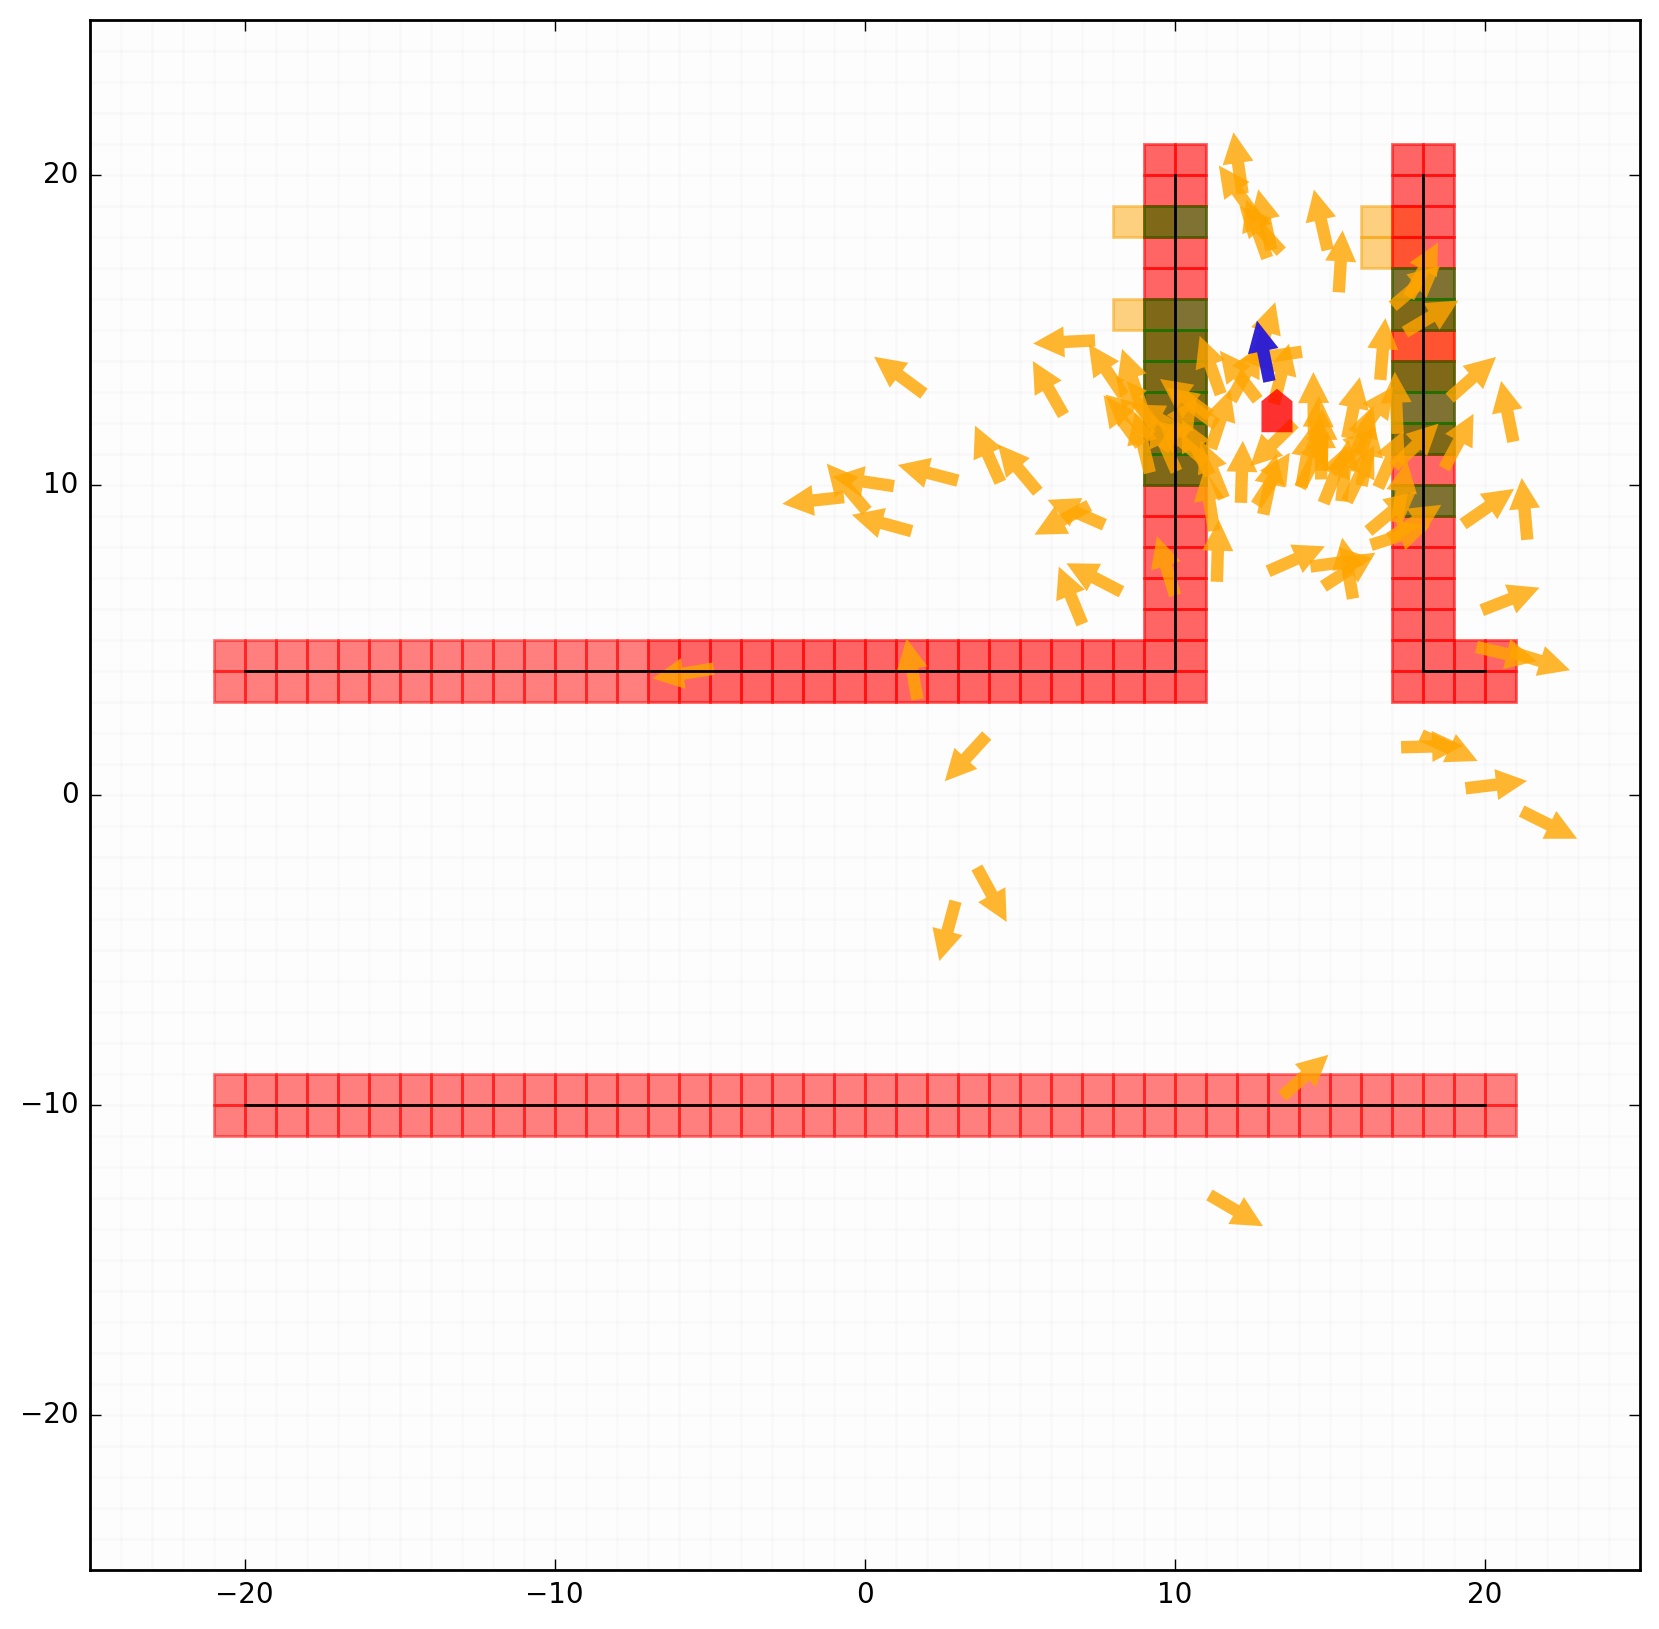

In [41]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)

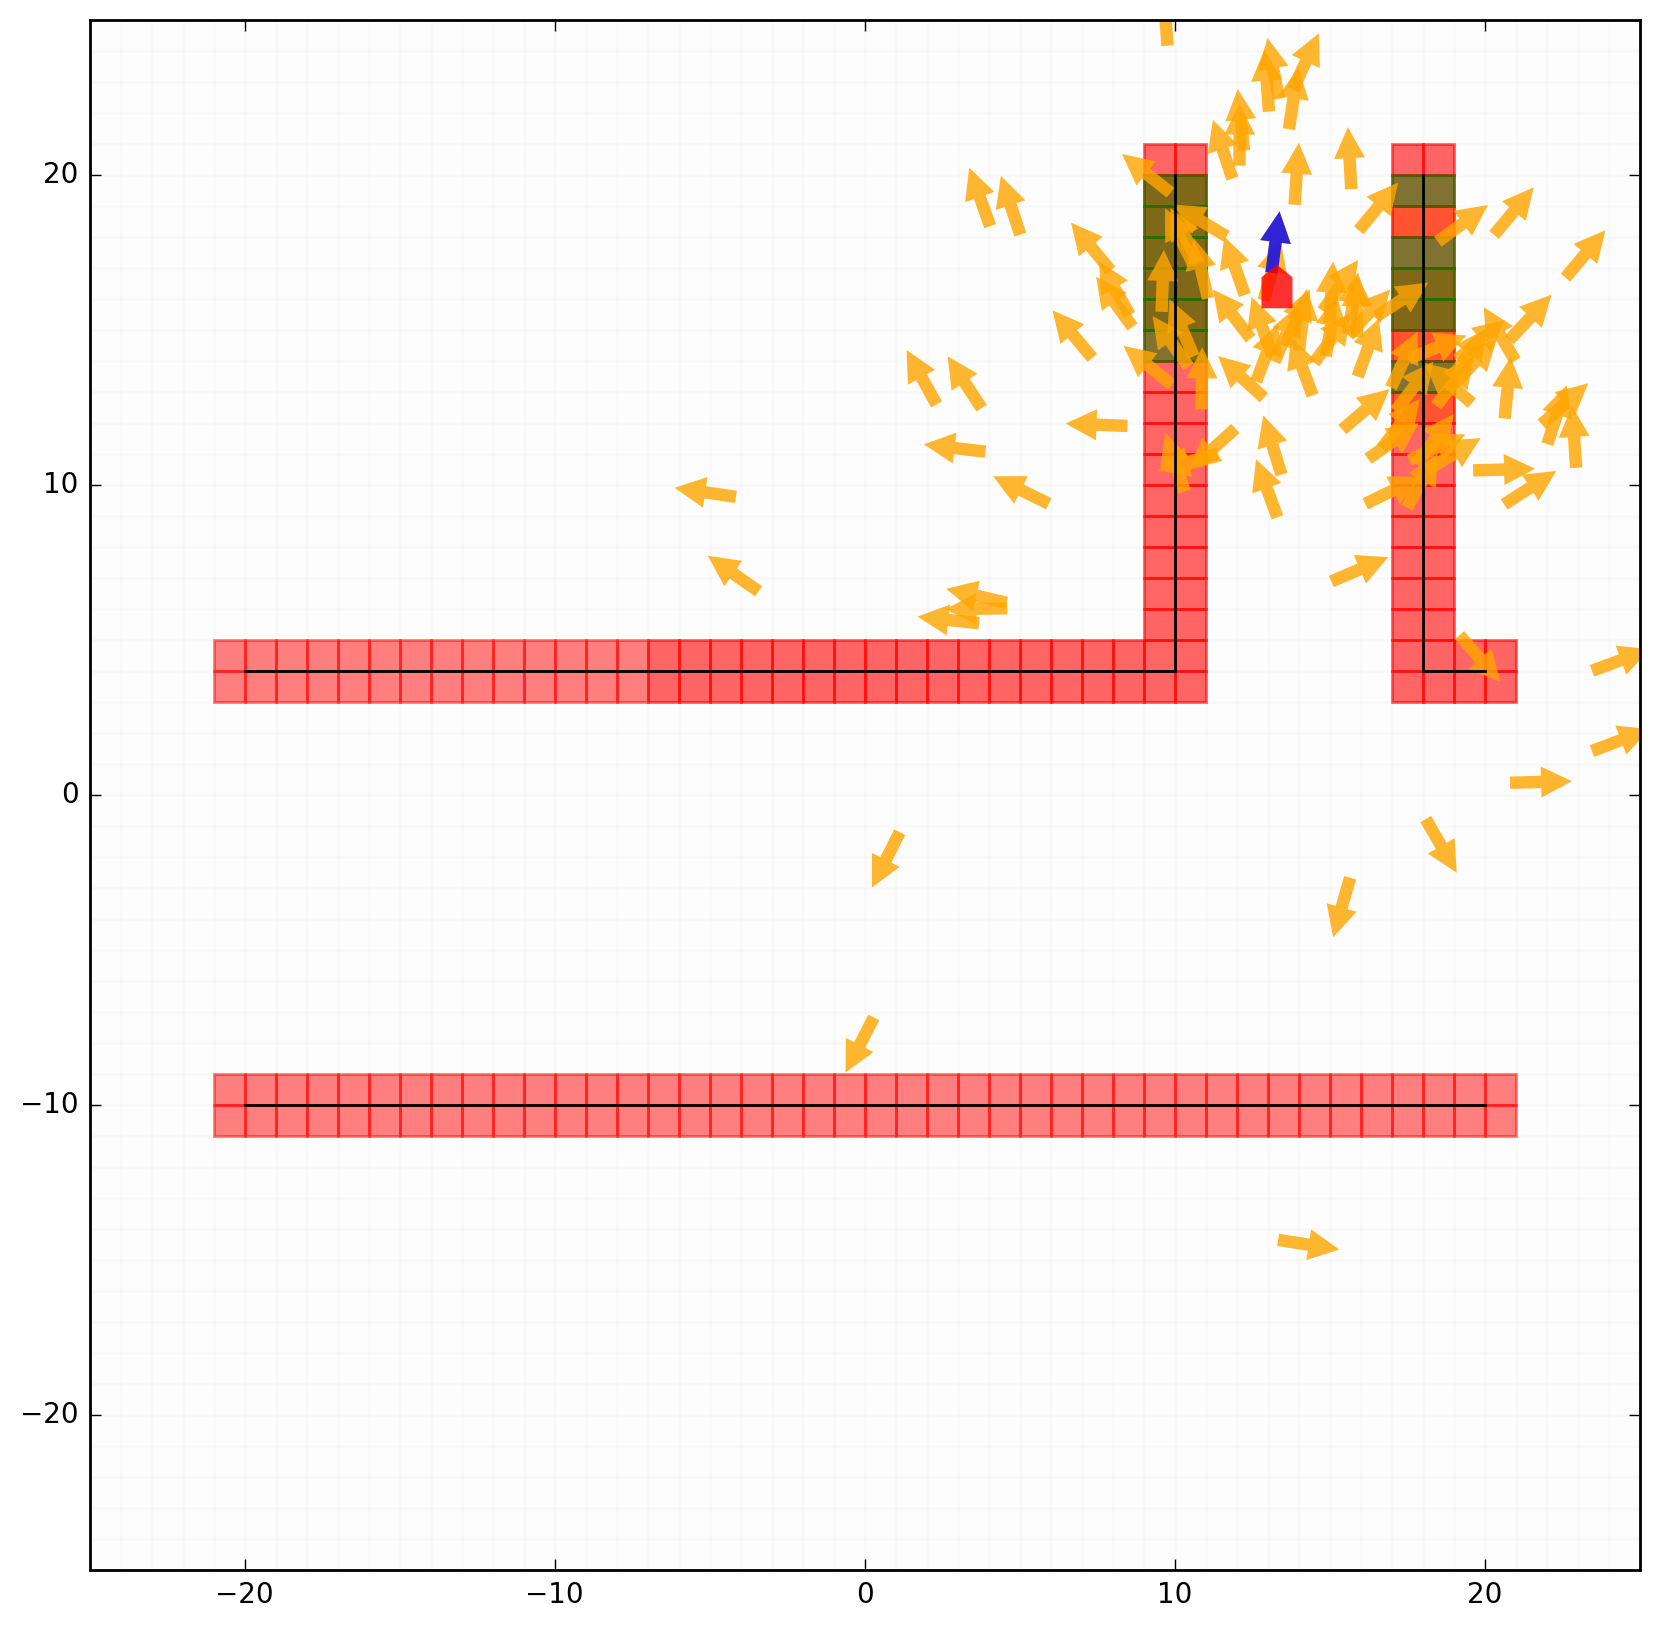

In [42]:
set_velocity(r, 4, 0)
p = resampling(p, gm, lm)
update_playground(50, 50, r, p, w, s, gm, lm)